In [1]:
# Cell 1: Setup (imports, config, helpers)

import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

# Reproducibility
RNG_SEED = 7
rng = np.random.default_rng(RNG_SEED)

# Numerical settings
np.set_printoptions(precision=4, suppress=True)

def symmetrize(M: np.ndarray) -> np.ndarray:
    """Force a matrix to be symmetric (useful for numerics)."""
    return 0.5 * (M + M.T)

def assert_close(a, b, tol=1e-8, name="value"):
    """Simple assert for notebook validation."""
    err = np.max(np.abs(a - b))
    if err > tol:
        raise AssertionError(f"{name} not close: max|diff|={err:.3e} > {tol:.3e}")
    return err

def explained_variance_ratio(evals: np.ndarray, R: int) -> float:
    """Cumulative explained variance ratio using eigenvalues."""
    evals = np.maximum(evals, 0.0)
    return float(np.sum(evals[:R]) / np.sum(evals))

In [2]:
# Cell 2: Frequency grid + quadrature weights (uniform grid)

# ---- Choose a working example configuration ----
B_total = 1.0e6     # total bandwidth in Hz (example; can change later)
M = 512             # number of frequency bins

# Frequency grid (centered, uniform spacing)
df = B_total / M
f = (np.arange(M) - M/2) * df   # Hz, centered at 0

# Quadrature weights (Lebesgue measure approx.)
w = np.full(M, df)

# ---- Validations from the document ----
# 1) Sum of weights equals total bandwidth
w_sum = np.sum(w)

print(f"B_total = {B_total:.3e} Hz")
print(f"M = {M}, df = {df:.3e} Hz")
print(f"sum(w) = {w_sum:.6e} Hz")

assert_close(w_sum, B_total, tol=1e-10 * B_total, name="sum(w) vs B_total")

# 2) Basic sanity checks
assert f.shape == (M,)
assert w.shape == (M,)
assert np.all(w > 0)

print("Grid + weights validation passed.")


B_total = 1.000e+06 Hz
M = 512, df = 1.953e+03 Hz
sum(w) = 1.000000e+06 Hz
Grid + weights validation passed.


Kw symmetry max|Kw-Kw^T| = 0.000e+00
Kw eigval min = 6.300e-03, max = 2.198e+05


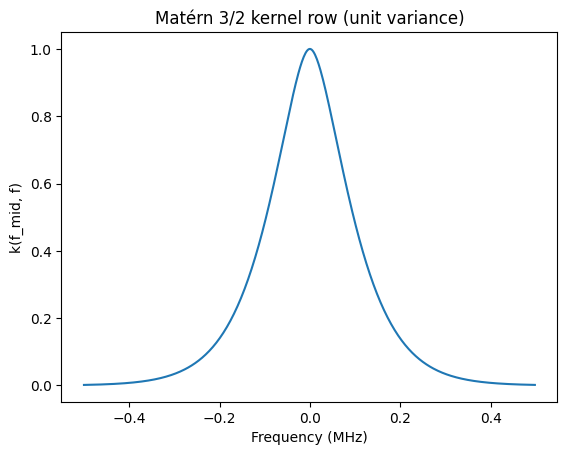

Kernel + Kw validation passed.


In [3]:
# Cell 3: Frequency kernel (Matérn 3/2) + weighted Gram matrix Kw

def matern32_kernel_1d(x: np.ndarray, y: np.ndarray, ell: float) -> np.ndarray:
    """
    Matérn ν=3/2 kernel in 1D with unit variance (k(0)=1).
    k(r) = (1 + sqrt(3) r/ell) * exp(-sqrt(3) r/ell)
    """
    x = x[:, None]
    y = y[None, :]
    r = np.abs(x - y)
    a = np.sqrt(3.0) * r / ell
    return (1.0 + a) * np.exp(-a)

# ---- Hyperparameter: frequency lengthscale ----
# Document suggests starting around 0.1 * B_total for typical spectra
ell_f = 0.1 * B_total

# Unweighted kernel matrix K (unit variance)
K = matern32_kernel_1d(f, f, ell=ell_f)

# Weighted Gram matrix Kw = K ⊙ sqrt(w_i w_j)
sqrtw = np.sqrt(w)
Kw = K * (sqrtw[:, None] * sqrtw[None, :])

# ---- Validations ----
# 1) Symmetry
Kw_sym_err = np.max(np.abs(Kw - Kw.T))
print(f"Kw symmetry max|Kw-Kw^T| = {Kw_sym_err:.3e}")
assert Kw_sym_err < 1e-10 * np.max(np.abs(Kw))

# 2) Positive semidefinite (numerically): eigenvalues should be >= small negative tol
# (Tiny negatives can happen due to floating point.)
evals = npl.eigvalsh(symmetrize(Kw))
min_eval = float(np.min(evals))
print(f"Kw eigval min = {min_eval:.3e}, max = {float(np.max(evals)):.3e}")

# Allow a small negative tolerance relative to scale
tol_psd = 1e-10 * float(np.max(evals))
assert min_eval > -tol_psd, f"Kw not PSD within tolerance: min_eval={min_eval:.3e}"

# 3) Quick diagnostic plot of kernel row (shape sanity)
mid = M // 2
plt.figure()
plt.plot(f/1e6, K[mid, :])
plt.xlabel("Frequency (MHz)")
plt.ylabel("k(f_mid, f)")
plt.title("Matérn 3/2 kernel row (unit variance)")
plt.show()

print("Kernel + Kw validation passed.")

Chosen R = 20 to reach cumulative ratio 0.9910 (target=0.99)
Max orthonormality error ||Phi^T W Phi - I||_max = 1.110e-15


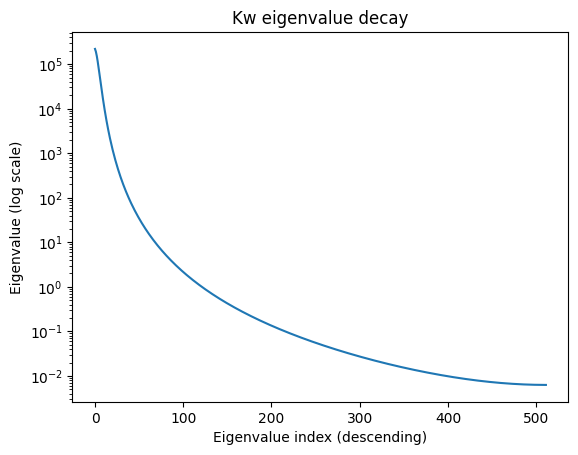

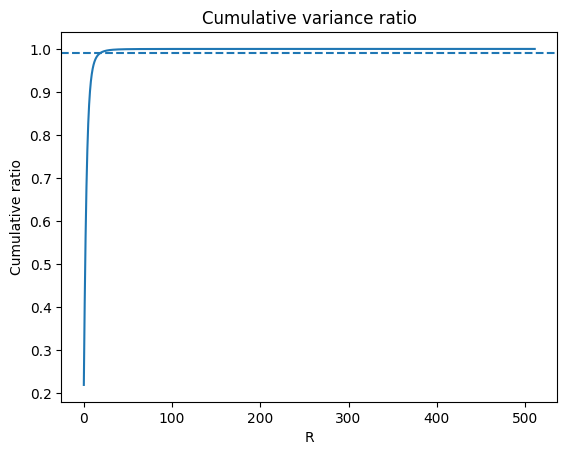

KL basis + truncation validation passed.


In [4]:
# Cell 4: KL basis from Kw (eigendecomposition) + truncation + orthonormality check

# Eigendecomposition (Kw is symmetric PSD)
evals, evecs = npl.eigh(symmetrize(Kw))  # ascending
idx = np.argsort(evals)[::-1]            # descending
evals = evals[idx]
evecs = evecs[:, idx]

# Choose R based on cumulative variance target (doc suggests 0.95-0.99)
target = 0.99
cum = np.cumsum(np.maximum(evals, 0.0))
total = cum[-1]
cum_ratio = cum / total

R = int(np.searchsorted(cum_ratio, target) + 1)
R = max(1, min(R, M))

print(f"Chosen R = {R} to reach cumulative ratio {cum_ratio[R-1]:.4f} (target={target})")

# Keep top-R modes
lam = evals[:R]          # (R,)
V = evecs[:, :R]         # (M,R)

# Discrete eigenfunctions on grid:
# phi_n(f_i) ≈ v_n[i] / sqrt(w_i)
Phi = V / sqrtw[:, None]   # (M,R)

# Validate weighted orthonormality: Phi^T diag(w) Phi ≈ I
G = Phi.T @ (w[:, None] * Phi)   # (R,R)
I = np.eye(R)
ortho_err = np.max(np.abs(G - I))

print(f"Max orthonormality error ||Phi^T W Phi - I||_max = {ortho_err:.3e}")

# tolerance: should be small; loosen slightly for large M / numerical issues
assert ortho_err < 5e-6, f"Weighted orthonormality too poor: {ortho_err:.3e}"

# Diagnostic: eigenvalue decay plot
plt.figure()
plt.semilogy(np.maximum(evals, 1e-30))
plt.xlabel("Eigenvalue index (descending)")
plt.ylabel("Eigenvalue (log scale)")
plt.title("Kw eigenvalue decay")
plt.show()

# Diagnostic: cumulative ratio plot
plt.figure()
plt.plot(cum_ratio)
plt.axhline(target, linestyle="--")
plt.xlabel("R")
plt.ylabel("Cumulative ratio")
plt.title("Cumulative variance ratio")
plt.show()

print("KL basis + truncation validation passed.")


In [5]:
# Cell 5: Build KL feature matrix Phi_KL and validate covariance construction

# Phi (M,R) and lam (R,) were created in Cell 4
# Feature matrix: Phi_KL[i,n] = sqrt(lam[n]) * Phi[i,n]
Phi_KL = Phi * np.sqrt(lam)[None, :]   # (M,R)

print("Phi_KL shape:", Phi_KL.shape)

# Validate induced (truncated) covariance:
# C_trunc = Phi_KL Phi_KL^T = sum_n lam_n * phi_n phi_n^T
C_from_features = Phi_KL @ Phi_KL.T

# Compute same covariance explicitly via sum of rank-1 terms
C_explicit = np.zeros((M, M))
for n in range(R):
    C_explicit += lam[n] * np.outer(Phi[:, n], Phi[:, n])

# Compare
cov_err = np.max(np.abs(C_from_features - C_explicit))
cov_scale = np.max(np.abs(C_explicit))
print(f"Max |C_feat - C_explicit| = {cov_err:.3e} (scale {cov_scale:.3e})")

assert cov_err < 1e-8 * max(1.0, cov_scale), "Covariance construction mismatch"

# Quick sanity: diagonal should be nonnegative
diag_min = float(np.min(np.diag(C_from_features)))
print(f"min diag(C_trunc) = {diag_min:.3e}")
assert diag_min > -1e-12 * max(1.0, cov_scale)

print("Phi_KL construction validation passed.")


Phi_KL shape: (512, 20)
Max |C_feat - C_explicit| = 4.441e-16 (scale 9.968e-01)
min diag(C_trunc) = 9.698e-01
Phi_KL construction validation passed.


signal_std=5.380e-01, sigma_eps=5.380e-02
RMSE = 1.165e-02
Relative RMSE (vs std of s_true) = 0.022
Empirical 95% band coverage = 0.943


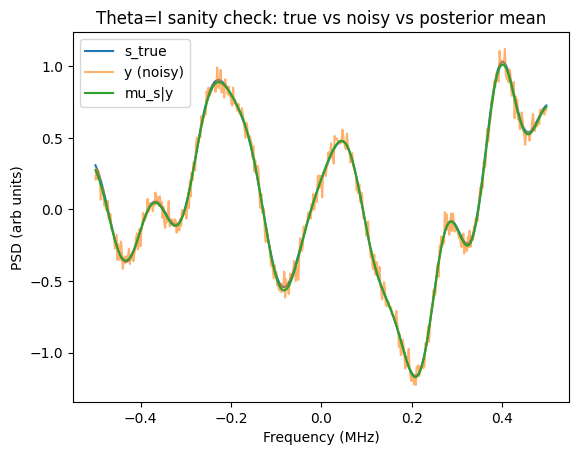

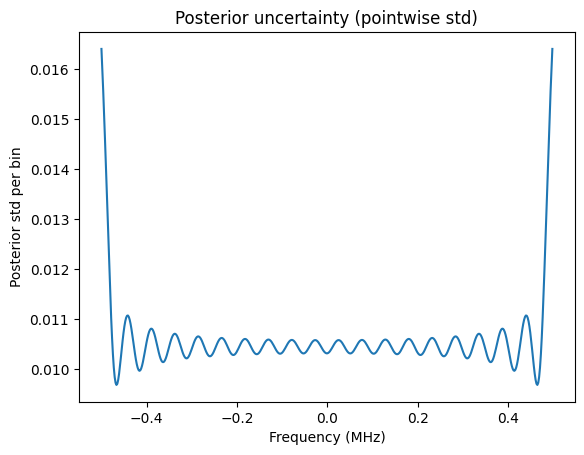

Static posterior with Theta=I validation passed.


In [6]:
# Cell 6: Static model sanity check with Theta = I (no compression)

# --- Define sensing operator Theta = I ---
N = M
Theta = np.eye(M)               # (N,M)
A = Theta @ Phi_KL              # (N,R) = (M,R)

# --- Synthetic ground truth from KL prior ---
xi_true = rng.standard_normal(R)            # xi ~ N(0, I)
s_true = Phi_KL @ xi_true                   # s = Phi_KL xi

# --- Noise model: epsilon ~ N(0, sigma_eps^2 I) ---
# Choose noise relative to signal scale (SNR-ish). Adjust later.
signal_std = float(np.std(s_true))
sigma_eps = 0.10 * signal_std               # 10% of signal std
Sigma_eps = (sigma_eps**2) * np.eye(N)

# Measurements
eps = sigma_eps * rng.standard_normal(N)
y = Theta @ s_true + eps                     # here Theta=I so y = s_true + eps

print(f"signal_std={signal_std:.3e}, sigma_eps={sigma_eps:.3e}")

# --- Posterior over xi (document eqs 8a, 8b) ---
# Since Sigma_eps is diagonal scalar here, we can use fast forms.
# General form: Sigma_xi = (I + A^T Sigma_eps^{-1} A)^-1
inv_sigma2 = 1.0 / (sigma_eps**2)
S = np.eye(R) + inv_sigma2 * (A.T @ A)       # (R,R)
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ (inv_sigma2 * (A.T @ y))

# --- Reconstruct PSD posterior mean/cov (document eqs 9a, 9b) ---
mu_s = Phi_KL @ mu_xi                         # (M,)
Sigma_s = Phi_KL @ Sigma_xi @ Phi_KL.T        # (M,M)
std_s = np.sqrt(np.maximum(np.diag(Sigma_s), 0.0))

# --- Validation metrics ---
rmse = float(np.sqrt(np.mean((mu_s - s_true)**2)))
rel_rmse = rmse / (float(np.std(s_true)) + 1e-12)

# Empirical coverage of 95% pointwise credible bands (should be ~0.95 in ideal world)
z = 1.96
covered = np.mean((s_true >= (mu_s - z*std_s)) & (s_true <= (mu_s + z*std_s)))

print(f"RMSE = {rmse:.3e}")
print(f"Relative RMSE (vs std of s_true) = {rel_rmse:.3f}")
print(f"Empirical 95% band coverage = {covered:.3f}")

# --- Plot a quick comparison ---
plt.figure()
plt.plot(f/1e6, s_true, label="s_true")
plt.plot(f/1e6, y, label="y (noisy)", alpha=0.6)
plt.plot(f/1e6, mu_s, label="mu_s|y")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (arb units)")
plt.title("Theta=I sanity check: true vs noisy vs posterior mean")
plt.legend()
plt.show()

plt.figure()
plt.plot(f/1e6, std_s)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Posterior std per bin")
plt.title("Posterior uncertainty (pointwise std)")
plt.show()

# --- Minimal pass/fail sanity thresholds (not too strict) ---
assert rel_rmse < 0.35, "Recovery is unexpectedly poor for Theta=I; something may be off."
assert 0.85 <= covered <= 0.99, "Credible interval coverage looks off (could be a bug or too-small R)."

print("Static posterior with Theta=I validation passed.")


N=128, M=512, compression=0.250, sigma_eps=5.380e-02
RMSE = 2.820e-02
Relative RMSE (vs std of s_true) = 0.052
Empirical 95% band coverage = 0.932


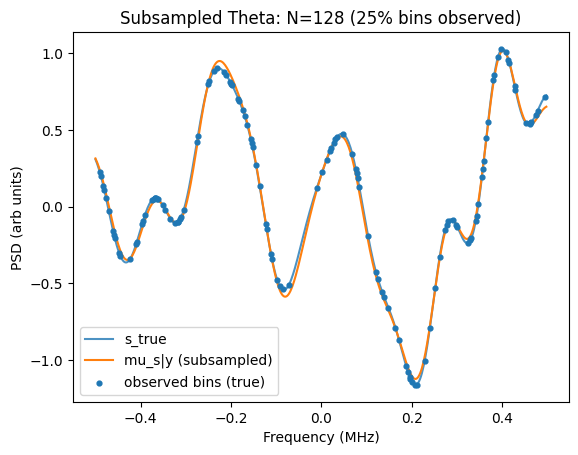

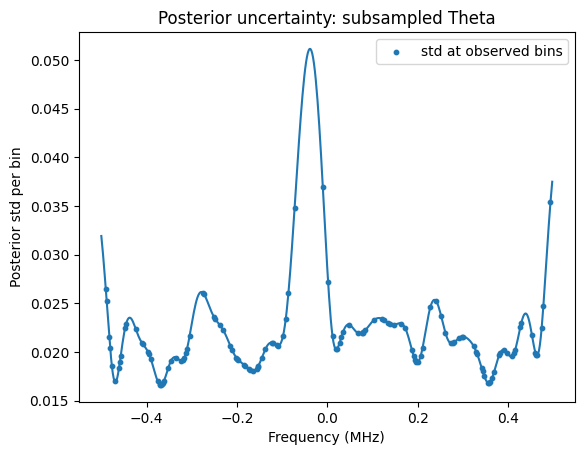

Subsampled Theta validation passed.


In [7]:
# Cell 7: Static inference with subsampling Theta (N << M)

# --- Choose number of measurements ---
N = M // 4   # 25% of bins observed (change later: M//8, M//16, etc.)

# Pick observed indices uniformly at random (without replacement)
obs_idx = np.sort(rng.choice(M, size=N, replace=False))

# Build Theta as a row-selector: y = Theta s + eps  =>  y = s[obs_idx] + eps
Theta = np.zeros((N, M))
Theta[np.arange(N), obs_idx] = 1.0

# Measurement matrix in coefficient space
A = Theta @ Phi_KL     # (N,R)

# --- Use the SAME ground-truth PSD as before (s_true) ---
# (If you'd rather resample each time, we can, but reusing helps debugging.)
# Generate measurements
signal_std = float(np.std(s_true))
sigma_eps = 0.10 * signal_std
inv_sigma2 = 1.0 / (sigma_eps**2)

y = Theta @ s_true + sigma_eps * rng.standard_normal(N)

print(f"N={N}, M={M}, compression={N/M:.3f}, sigma_eps={sigma_eps:.3e}")

# --- Posterior over xi ---
S = np.eye(R) + inv_sigma2 * (A.T @ A)     # (R,R)
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ (inv_sigma2 * (A.T @ y))

# --- Reconstruct PSD posterior ---
mu_s = Phi_KL @ mu_xi
Sigma_s = Phi_KL @ Sigma_xi @ Phi_KL.T
std_s = np.sqrt(np.maximum(np.diag(Sigma_s), 0.0))

# --- Metrics ---
rmse = float(np.sqrt(np.mean((mu_s - s_true)**2)))
rel_rmse = rmse / (float(np.std(s_true)) + 1e-12)

# Credible band coverage (pointwise)
z = 1.96
covered = np.mean((s_true >= (mu_s - z*std_s)) & (s_true <= (mu_s + z*std_s)))

print(f"RMSE = {rmse:.3e}")
print(f"Relative RMSE (vs std of s_true) = {rel_rmse:.3f}")
print(f"Empirical 95% band coverage = {covered:.3f}")

# --- Plot: posterior mean with observed points highlighted ---
plt.figure()
plt.plot(f/1e6, s_true, label="s_true", alpha=0.8)
plt.plot(f/1e6, mu_s, label="mu_s|y (subsampled)")
plt.scatter((f[obs_idx]/1e6), (s_true[obs_idx]), s=12, label="observed bins (true)", zorder=3)
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (arb units)")
plt.title(f"Subsampled Theta: N={N} ({N/M:.0%} bins observed)")
plt.legend()
plt.show()

# --- Plot uncertainty (should be lower near observed bins, higher elsewhere) ---
plt.figure()
plt.plot(f/1e6, std_s)
plt.scatter((f[obs_idx]/1e6), std_s[obs_idx], s=10, label="std at observed bins")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Posterior std per bin")
plt.title("Posterior uncertainty: subsampled Theta")
plt.legend()
plt.show()

# --- Very mild sanity expectations ---
# Recovery will degrade vs Theta=I, but shouldn't be totally broken at 25% sampling.
assert rel_rmse < 0.70, "Recovery seems too poor for 25% subsampling. Check R, ell_f, sigma_eps."
print("Subsampled Theta validation passed.")


P_fa=0.001, Qinv(P_fa)=3.090, gamma=56.253, tau_B=1.657e-01


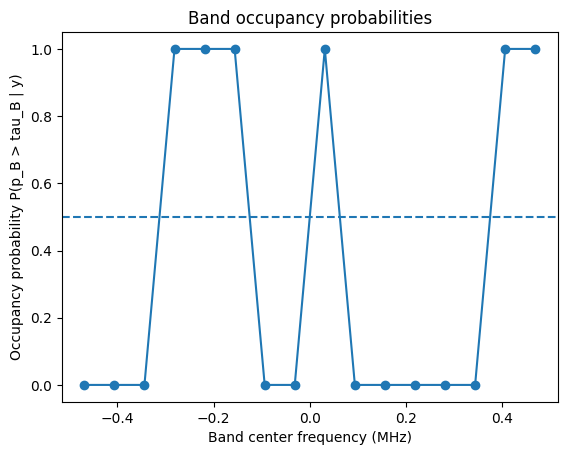

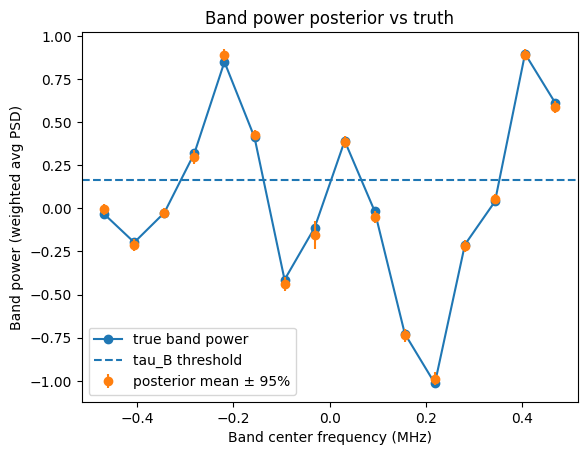

Occupancy module validation passed.


In [8]:
# Cell 8: Band power + occupancy probability (static), per the document

# --- Utilities: Normal CDF and Q^{-1} ---
def norm_cdf(x):
    # standard normal CDF using scipy if available, else numpy erf
    try:
        from scipy.stats import norm
        return norm.cdf(x)
    except Exception:
        # fallback: Phi(x) = 0.5*(1+erf(x/sqrt(2)))
        from math import erf, sqrt
        x = np.asarray(x)
        return 0.5 * (1.0 + np.vectorize(erf)(x / np.sqrt(2.0)))

def Qinv(p):
    """
    Q^{-1}(p) where Q(x)=P(Z>x)=1-Phi(x), Z~N(0,1).
    So Q^{-1}(p) = Phi^{-1}(1-p).
    """
    try:
        from scipy.stats import norm
        return float(norm.ppf(1.0 - p))
    except Exception:
        # fallback using scipy.special.erfcinv if available
        try:
            from scipy.special import erfcinv
            # Q(x) = 0.5*erfc(x/sqrt(2)) => x = sqrt(2)*erfcinv(2p)
            return float(np.sqrt(2.0) * erfcinv(2.0 * p))
        except Exception as e:
            raise RuntimeError("Need scipy for inverse CDF / erfcinv to compute Qinv.") from e

def band_selector_c(f, w, f_lo, f_hi):
    """Create c_B for band B defined by frequency limits [f_lo, f_hi)."""
    idx = np.where((f >= f_lo) & (f < f_hi))[0]
    if len(idx) == 0:
        raise ValueError("Band has zero bins; adjust f_lo/f_hi or grid.")
    c = np.zeros_like(w, dtype=float)
    c[idx] = w[idx] / np.sum(w[idx])
    return idx, c

def band_power_posterior(mu_s, Sigma_s, c):
    """Return (mu_B, var_B) for p_B = c^T s given posterior over s."""
    mu_B = float(c @ mu_s)
    var_B = float(c @ Sigma_s @ c)
    var_B = max(var_B, 0.0)
    return mu_B, var_B

def occupancy_prob(mu_B, var_B, tau_B):
    """P(p_B > tau_B | y) for Gaussian p_B."""
    sigma_B = np.sqrt(max(var_B, 1e-30))
    z = (tau_B - mu_B) / sigma_B
    return float(1.0 - norm_cdf(z))

# --- Define a few contiguous bands across the spectrum ---
# We'll split into K equal-width bands for a simple occupancy map
K = 16
band_edges = np.linspace(f.min(), f.max() + df, K + 1)  # include top edge

bands = []
for k in range(K):
    f_lo, f_hi = band_edges[k], band_edges[k+1]
    idx, cB = band_selector_c(f, w, f_lo, f_hi)
    bands.append((f_lo, f_hi, idx, cB))

# --- Threshold setting per document ---
P_fa = 1e-3
gamma = np.sqrt(2.0 * M * Qinv(P_fa))     # doc formula
tau_B = (sigma_eps**2) * (1.0 + gamma)   # doc formula (uses noise variance)

print(f"P_fa={P_fa}, Qinv(P_fa)={Qinv(P_fa):.3f}, gamma={gamma:.3f}, tau_B={tau_B:.3e}")

# --- Compute occupancy probabilities for each band ---
mu_B_list, var_B_list, occp_list, ptrue_list = [], [], [], []

for (f_lo, f_hi, idx, cB) in bands:
    mu_B, var_B = band_power_posterior(mu_s, Sigma_s, cB)
    p_occ = occupancy_prob(mu_B, var_B, tau_B)

    # ground-truth band power using s_true (for validation)
    p_true = float(cB @ s_true)

    mu_B_list.append(mu_B)
    var_B_list.append(var_B)
    occp_list.append(p_occ)
    ptrue_list.append(p_true)

mu_B_arr = np.array(mu_B_list)
std_B_arr = np.sqrt(np.maximum(np.array(var_B_list), 0.0))
occp_arr = np.array(occp_list)
ptrue_arr = np.array(ptrue_list)

# --- Plot occupancy probabilities across bands ---
band_centers = 0.5 * (band_edges[:-1] + band_edges[1:])

plt.figure()
plt.plot(band_centers/1e6, occp_arr, marker="o")
plt.axhline(0.5, linestyle="--")
plt.xlabel("Band center frequency (MHz)")
plt.ylabel("Occupancy probability P(p_B > tau_B | y)")
plt.title("Band occupancy probabilities")
plt.ylim(-0.05, 1.05)
plt.show()

# --- Plot band power: true vs posterior mean with ±1.96 std ---
plt.figure()
plt.plot(band_centers/1e6, ptrue_arr, marker="o", label="true band power")
plt.errorbar(band_centers/1e6, mu_B_arr, yerr=1.96*std_B_arr, fmt="o", label="posterior mean ± 95%")
plt.axhline(tau_B, linestyle="--", label="tau_B threshold")
plt.xlabel("Band center frequency (MHz)")
plt.ylabel("Band power (weighted avg PSD)")
plt.title("Band power posterior vs truth")
plt.legend()
plt.show()

# --- Simple sanity checks ---
assert np.all((occp_arr >= 0.0) & (occp_arr <= 1.0)), "Occupancy probabilities out of [0,1]"
print("Occupancy module validation passed.")


## more difficult

Hard synthetic data generated.
s_true std: 1.207e+00
y std:      1.362e+00
noise std:  3.983e-01
impulsive frac approx: 0.030


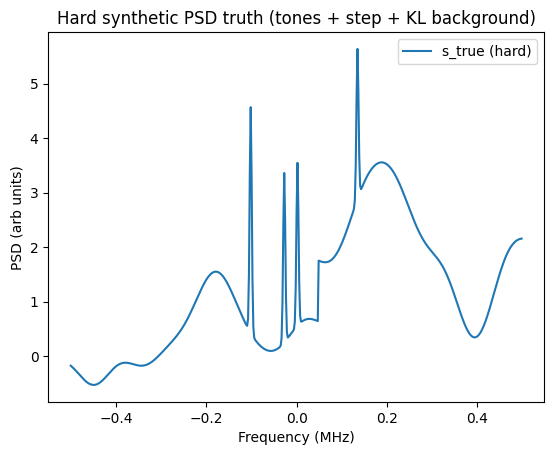

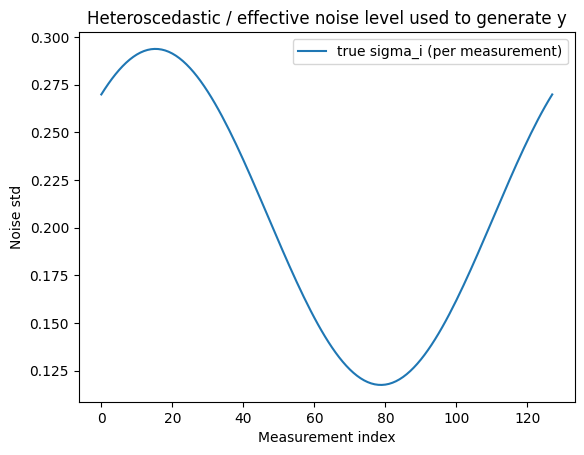

In [9]:
# Cell 9: Harder synthetic data (truth + harder noise/interference)

def gaussian_bump(f, f0, bw, amp):
    """Gaussian bump centered at f0 with bandwidth bw (std dev in Hz)."""
    return amp * np.exp(-0.5 * ((f - f0) / bw) ** 2)

def make_harder_psd_truth(f, Phi_KL, rng,
                         use_KL_background=True,
                         n_tones=3,
                         tone_bw_bins=2.0,
                         tone_amp=3.0,
                         add_step=True,
                         step_amp=1.0):
    """
    Build a harder PSD truth:
      - smooth KL background (optional)
      - plus narrowband "tones"/spikes (Gaussian bumps)
      - plus an optional step/edge feature
    """
    M = f.size
    df = float(np.mean(np.diff(f)))
    
    s = np.zeros(M)

    # 1) Smooth background from KL prior (what model expects)
    if use_KL_background:
        R = Phi_KL.shape[1]
        xi = rng.standard_normal(R)
        s += Phi_KL @ xi

    # 2) Add narrowband tones/spikes (harder than smooth GP)
    tone_bw = tone_bw_bins * df
    # Choose tone centers away from edges
    margin = int(0.1 * M)
    tone_bins = rng.choice(np.arange(margin, M - margin), size=n_tones, replace=False)
    for b in tone_bins:
        f0 = f[b]
        # random sign/amp (keep positive bias if you want “power-like”)
        amp = tone_amp * np.std(s + 1e-12) * (0.7 + 0.6 * rng.random())
        s += gaussian_bump(f, f0=f0, bw=tone_bw, amp=amp)

    # 3) Add a step/edge feature (also hard for smooth priors)
    if add_step:
        step_bin = int(0.55 * M)
        s += step_amp * np.std(s + 1e-12) * (f >= f[step_bin]).astype(float)

    return s

def make_measurements(Theta, s_true, rng,
                      base_sigma=0.10,
                      heteroscedastic=True,
                      correlated=False,
                      impulsive=True,
                      impulse_prob=0.02,
                      impulse_scale=8.0):
    """
    Generate y = Theta s + eps with:
      - base iid noise
      - optional heteroscedastic noise (freq-dependent variance)
      - optional correlated noise across measurement indices
      - optional impulsive outliers
    Returns: y, sigma_i (per-measure std), eps (noise realization)
    """
    y_clean = Theta @ s_true
    N = y_clean.size

    # baseline sigma relative to signal std in measurement space
    sig0 = base_sigma * float(np.std(y_clean) + 1e-12)

    # heteroscedastic: vary sigma across measurement indices
    if heteroscedastic:
        # smooth variation factor in [0.5, 2.0] approximately
        t = np.linspace(0, 1, N)
        factor = 0.8 + 1.2 * (0.5 + 0.5*np.sin(2*np.pi*(t + 0.13)))
        sigma_i = sig0 * factor
    else:
        sigma_i = np.full(N, sig0)

    # iid noise draw
    eps = sigma_i * rng.standard_normal(N)

    # correlated noise (simple AR(1)-like correlation in measurement index order)
    if correlated:
        rho = 0.85
        eps_corr = np.zeros(N)
        for i in range(N):
            eps_corr[i] = (rho * eps_corr[i-1] if i > 0 else 0.0) + eps[i]
        # renormalize to keep comparable scale
        eps = eps_corr / np.std(eps_corr) * np.std(eps)

    # impulsive outliers
    if impulsive:
        mask = rng.random(N) < impulse_prob
        eps[mask] += impulse_scale * sig0 * rng.standard_normal(np.sum(mask))

    y = y_clean + eps
    return y, sigma_i, eps

# -----------------------
# Difficulty knobs
# -----------------------
HARD = dict(
    use_KL_background=True,   # keep some structure the model can capture
    n_tones=4,                # more tones = harder
    tone_bw_bins=1.2,         # narrower = harder
    tone_amp=4.0,             # stronger tones = harder
    add_step=True,
    step_amp=1.2
)

NOISE = dict(
    base_sigma=0.12,          # baseline noise level
    heteroscedastic=True,     # varying noise floor
    correlated=True,          # colored/correlated noise
    impulsive=True,           # outliers/interference
    impulse_prob=0.03,
    impulse_scale=10.0
)

# -----------------------
# Generate harder truth + measurements
# -----------------------
s_true = make_harder_psd_truth(f, Phi_KL, rng, **HARD)

# Use current Theta from Cell 7 (subsampled row-selector)
y, sigma_i_true, eps = make_measurements(Theta, s_true, rng, **NOISE)

print("Hard synthetic data generated.")
print(f"s_true std: {np.std(s_true):.3e}")
print(f"y std:      {np.std(y):.3e}")
print(f"noise std:  {np.std(eps):.3e}")
print(f"impulsive frac approx: {NOISE['impulse_prob']:.3f}")

# Plot truth PSD
plt.figure()
plt.plot(f/1e6, s_true, label="s_true (hard)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (arb units)")
plt.title("Hard synthetic PSD truth (tones + step + KL background)")
plt.legend()
plt.show()

# Plot measurement noise sigma profile (in measurement index space)
plt.figure()
plt.plot(sigma_i_true, label="true sigma_i (per measurement)")
plt.xlabel("Measurement index")
plt.ylabel("Noise std")
plt.title("Heteroscedastic / effective noise level used to generate y")
plt.legend()
plt.show()


Assumed iid sigma_eps_hat = 1.418e+00
Residual mean = 0.060
Residual std  = 0.393 (should be ~1 if noise model matches)


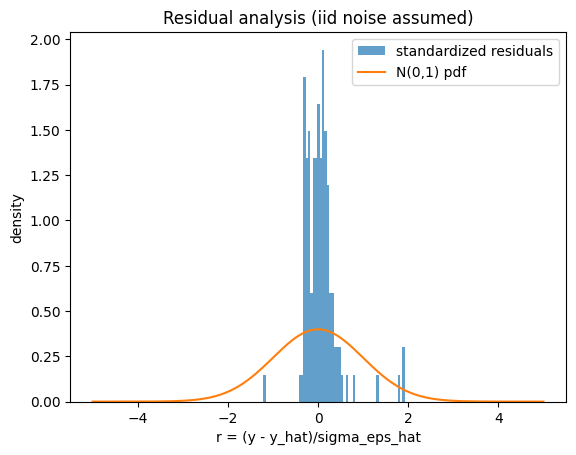

Fraction |r|>3: 0.000  (Gaussian expectation ~0.0027)
Fraction |r|>5: 0.000  (Gaussian expectation ~5.7e-07)


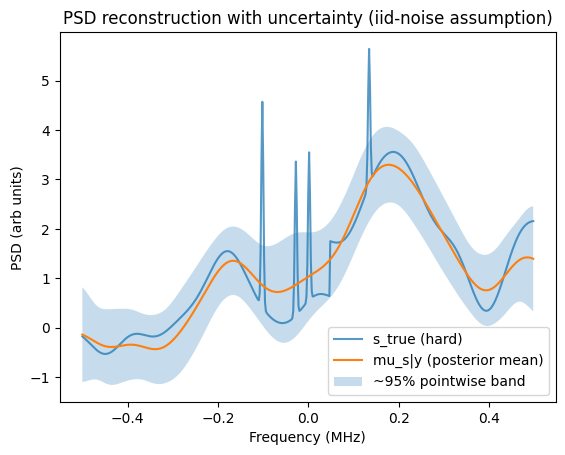

In [10]:
# Cell 10: Run static inference (assuming iid noise) + residual diagnostics

# A = Theta @ Phi_KL for current Theta
A = Theta @ Phi_KL
N = A.shape[0]

# --- Estimate a single sigma_eps from data (robust-ish) ---
# We'll use MAD on y as a crude proxy; later we'll do proper MLL learning.
med = np.median(y)
mad = np.median(np.abs(y - med)) + 1e-12
sigma_eps_hat = 1.4826 * mad  # MAD -> std for Gaussian
sigma_eps_hat = max(sigma_eps_hat, 1e-12)

inv_sigma2 = 1.0 / (sigma_eps_hat**2)

print(f"Assumed iid sigma_eps_hat = {sigma_eps_hat:.3e}")

# --- Posterior over xi (same formulas as before) ---
S = np.eye(R) + inv_sigma2 * (A.T @ A)
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ (inv_sigma2 * (A.T @ y))

# --- Posterior mean/covariance in measurement space ---
# Predicted mean of y: y_hat = A mu_xi
y_hat = A @ mu_xi

# Residuals (standardized using iid sigma_eps_hat)
r = (y - y_hat) / sigma_eps_hat

print(f"Residual mean = {np.mean(r):.3f}")
print(f"Residual std  = {np.std(r):.3f} (should be ~1 if noise model matches)")

# --- Plot residual histogram vs standard normal shape ---
plt.figure()
plt.hist(r, bins=60, density=True, alpha=0.7, label="standardized residuals")

# Overlay N(0,1) pdf
xx = np.linspace(-5, 5, 400)
pdf = (1.0 / np.sqrt(2*np.pi)) * np.exp(-0.5 * xx**2)
plt.plot(xx, pdf, label="N(0,1) pdf")
plt.xlabel("r = (y - y_hat)/sigma_eps_hat")
plt.ylabel("density")
plt.title("Residual analysis (iid noise assumed)")
plt.legend()
plt.show()

# --- Outlier rate check ---
out3 = np.mean(np.abs(r) > 3.0)
out5 = np.mean(np.abs(r) > 5.0)
print(f"Fraction |r|>3: {out3:.3f}  (Gaussian expectation ~0.0027)")
print(f"Fraction |r|>5: {out5:.3f}  (Gaussian expectation ~5.7e-07)")

# --- Reconstruct PSD posterior (optional, for visualization) ---
mu_s = Phi_KL @ mu_xi
Sigma_s = Phi_KL @ Sigma_xi @ Phi_KL.T
std_s = np.sqrt(np.maximum(np.diag(Sigma_s), 0.0))

alpha = 0.05
z = 1.96  # ~95% pointwise band

lower = mu_s - z * std_s
upper = mu_s + z * std_s

plt.figure()
plt.plot(f/1e6, s_true, label="s_true (hard)", alpha=0.75)
plt.plot(f/1e6, mu_s, label="mu_s|y (posterior mean)")
plt.fill_between(f/1e6, lower, upper, alpha=0.25, label="~95% pointwise band")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (arb units)")
plt.title("PSD reconstruction with uncertainty (iid-noise assumption)")
plt.legend()
plt.show()


In [11]:
# Cell 11: Static log marginal likelihood for (ell_f, sigma_eps) using Woodbury

from scipy.optimize import minimize

def build_Phi_KL_fixedR(f, w, ell_f, R, kernel_fn=matern32_kernel_1d):
    """
    Build Phi_KL (M,R) for a given ell_f, using:
      Kw_ij = k(f_i,f_j) * sqrt(w_i w_j)
      eigenpairs of Kw -> phi_n = v_n / sqrt(w)
      Phi_KL[:,n] = sqrt(lam_n) * phi_n
    """
    M = f.size
    sqrtw = np.sqrt(w)

    K = kernel_fn(f, f, ell=ell_f)
    Kw = K * (sqrtw[:, None] * sqrtw[None, :])

    # eigendecomposition
    evals, evecs = npl.eigh(symmetrize(Kw))
    idx = np.argsort(evals)[::-1]
    evals = evals[idx]
    evecs = evecs[:, idx]

    lam = np.maximum(evals[:R], 0.0)               # (R,)
    V = evecs[:, :R]                               # (M,R)
    Phi = V / sqrtw[:, None]                       # (M,R)
    Phi_KL = Phi * np.sqrt(lam)[None, :]           # (M,R)

    return Phi_KL, lam

def log_marginal_likelihood_static(y, Theta, f, w, ell_f, sigma_eps, R):
    """
    Computes log p(y | ell_f, sigma_eps) for the static model with:
      y = A xi + eps, xi ~ N(0,I), eps ~ N(0, sigma_eps^2 I)
      A = Theta Phi_KL(ell_f)
    Using:
      C = A A^T + sigma^2 I
      log p = -0.5 y^T C^{-1} y - 0.5 log|C| - N/2 log(2pi)
    Efficiently using Woodbury + determinant lemma:
      B = I + (1/sigma^2) A^T A  (size R)
      |C| = (sigma^2)^N |B|
      C^{-1} = (1/sigma^2)I - (1/sigma^4) A B^{-1} A^T
    """
    y = np.asarray(y).reshape(-1)
    N = y.size
    sigma2 = float(sigma_eps**2)
    if sigma2 <= 0:
        return -np.inf

    # Build Phi_KL for this ell_f
    Phi_KL, _ = build_Phi_KL_fixedR(f, w, ell_f=ell_f, R=R)

    A = Theta @ Phi_KL          # (N,R)

    # B = I + (1/sigma^2) A^T A  (R,R)
    AtA = A.T @ A
    B = np.eye(R) + (1.0/sigma2) * AtA
    B = symmetrize(B)

    # Cholesky for stability
    try:
        L = npl.cholesky(B)     # B = L L^T
    except npl.LinAlgError:
        return -np.inf

    # Compute quadratic form y^T C^{-1} y using Woodbury:
    # y^T C^{-1} y = (1/sigma^2) y^T y - (1/sigma^4) y^T A B^{-1} A^T y
    Aty = A.T @ y                               # (R,)
    # Solve B^{-1} A^T y via two triangular solves using Cholesky
    v = npl.solve(L, Aty)
    Binv_Aty = npl.solve(L.T, v)               # (R,)

    yTy = float(y @ y)
    corr = float(Aty @ Binv_Aty)               # = (A^T y)^T B^{-1} (A^T y)
    quad = (1.0/sigma2) * yTy - (1.0/(sigma2**2)) * corr

    # log|C| = N log(sigma^2) + log|B|, and log|B| = 2 * sum(log(diag(L)))
    logdetB = 2.0 * float(np.sum(np.log(np.diag(L) + 1e-30)))
    logdetC = N * np.log(sigma2) + logdetB

    ll = -0.5 * quad - 0.5 * logdetC - 0.5 * N * np.log(2.0*np.pi)
    return float(ll)

# ---- Quick sanity evaluation on a few parameter values ----
# We'll optimize over log-parameters later, but test numeric behavior now.
ell_test = ell_f                      # from earlier cells
sigma_test = max(np.std(y) * 0.1, 1e-8)

ll0 = log_marginal_likelihood_static(y, Theta, f, w, ell_test, sigma_test, R)
ll1 = log_marginal_likelihood_static(y, Theta, f, w, ell_test*0.5, sigma_test, R)
ll2 = log_marginal_likelihood_static(y, Theta, f, w, ell_test*2.0, sigma_test, R)

print(f"logML at ell={ell_test:.3e}, sigma={sigma_test:.3e}: {ll0:.3f}")
print(f"logML at ell={ell_test*0.5:.3e}: {ll1:.3f}")
print(f"logML at ell={ell_test*2.0:.3e}: {ll2:.3f}")
print("Cell 11 ready (log marginal likelihood implemented).")


logML at ell=1.000e+05, sigma=1.362e-01: -677.752
logML at ell=5.000e+04: -685.958
logML at ell=2.000e+05: -722.540
Cell 11 ready (log marginal likelihood implemented).


In [12]:
# Cell 12: Hyperparameter optimization (static) with multi-start L-BFGS-B

from scipy.optimize import minimize

# We'll optimize in log-space to enforce positivity:
#   x = [log_ell, log_sigma]
#   ell = exp(log_ell), sigma = exp(log_sigma)

def neg_logml_logparams(x, y, Theta, f, w, R):
    log_ell, log_sigma = float(x[0]), float(x[1])
    ell = float(np.exp(log_ell))
    sigma = float(np.exp(log_sigma))
    ll = log_marginal_likelihood_static(y, Theta, f, w, ell, sigma, R)
    # optimizer minimizes -> return negative log marginal likelihood
    if not np.isfinite(ll):
        return 1e30
    return -ll

# ---- Bounds (log-space) ----
# Frequency lengthscale ell_f should be within a sensible fraction of total bandwidth
# (These are broad; adjust later if needed.)
ell_min = 1e-3 * B_total
ell_max = 1.0  * B_total

# Noise sigma bounds: keep broad but avoid degenerate tiny values
sigma_min = 1e-6 * (np.std(y) + 1e-12)
sigma_max = 10.0 * (np.std(y) + 1e-12)

bounds = [(np.log(ell_min), np.log(ell_max)),
          (np.log(sigma_min), np.log(sigma_max))]

print("Bounds:")
print(f" ell in [{ell_min:.3e}, {ell_max:.3e}]")
print(f" sigma in [{sigma_min:.3e}, {sigma_max:.3e}]")

# ---- Multi-start initialization ----
n_restarts = 5
starts = []

# Start 1: current heuristic (near previous ell_f and MAD-ish sigma)
sigma_init = max(np.std(y) * 0.1, sigma_min)
starts.append(np.array([np.log(np.clip(ell_f, ell_min, ell_max)),
                        np.log(np.clip(sigma_init, sigma_min, sigma_max))]))

# Other starts: random within bounds (log-uniform)
for _ in range(n_restarts - 1):
    log_ell0 = rng.uniform(bounds[0][0], bounds[0][1])
    log_sig0 = rng.uniform(bounds[1][0], bounds[1][1])
    starts.append(np.array([log_ell0, log_sig0]))

results = []
best = None

for k, x0 in enumerate(starts, 1):
    res = minimize(
        neg_logml_logparams,
        x0=x0,
        args=(y, Theta, f, w, R),
        method="L-BFGS-B",
        bounds=bounds,
        options=dict(maxiter=60)
    )
    results.append(res)

    ell_hat = float(np.exp(res.x[0]))
    sig_hat = float(np.exp(res.x[1]))
    ll_hat = -float(res.fun)

    print(f"[restart {k}/{len(starts)}] success={res.success}  ll={ll_hat:.3f}  ell={ell_hat:.3e}  sigma={sig_hat:.3e}")

    if (best is None) or (res.fun < best.fun):
        best = res

# ---- Report best result ----
ell_opt = float(np.exp(best.x[0]))
sigma_opt = float(np.exp(best.x[1]))
ll_opt = -float(best.fun)

print("\nBest solution:")
print(f" logML = {ll_opt:.3f}")
print(f" ell_f = {ell_opt:.6e} Hz")
print(f" sigma_eps = {sigma_opt:.6e}")

# Optional: quick stability summary (spread across restarts)
ell_all = np.array([np.exp(r.x[0]) for r in results])
sig_all = np.array([np.exp(r.x[1]) for r in results])
ll_all  = np.array([-r.fun for r in results])

print("\nRestart summary:")
print(f" ell range:   [{ell_all.min():.3e}, {ell_all.max():.3e}]")
print(f" sigma range: [{sig_all.min():.3e}, {sig_all.max():.3e}]")
print(f" logML range: [{ll_all.min():.3f}, {ll_all.max():.3f}]")

# Save for later cells
ell_f_mll = ell_opt
sigma_eps_mll = sigma_opt


Bounds:
 ell in [1.000e+03, 1.000e+06]
 sigma in [1.362e-06, 1.362e+01]
[restart 1/5] success=True  ll=-125.876  ell=9.488e+04  sigma=5.095e-01
[restart 2/5] success=True  ll=-125.876  ell=9.488e+04  sigma=5.095e-01
[restart 3/5] success=True  ll=-125.876  ell=9.488e+04  sigma=5.095e-01
[restart 4/5] success=True  ll=-125.876  ell=9.488e+04  sigma=5.095e-01
[restart 5/5] success=True  ll=-125.876  ell=9.488e+04  sigma=5.095e-01

Best solution:
 logML = -125.876
 ell_f = 9.487806e+04 Hz
 sigma_eps = 5.094930e-01

Restart summary:
 ell range:   [9.488e+04, 9.488e+04]
 sigma range: [5.095e-01, 5.095e-01]
 logML range: [-125.876, -125.876]


Using ell_f_mll=9.488e+04, sigma_eps_mll=5.095e-01
Residual mean = 0.026
Residual std  = 0.936 (target ~1 if iid Gaussian noise matches)


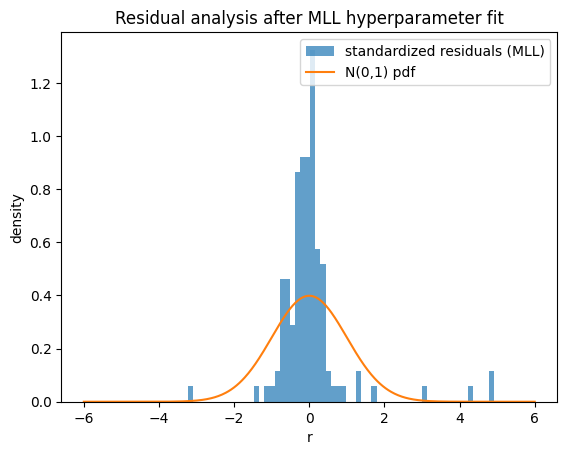

Fraction |r|>3: 0.039  (Gaussian expectation ~0.0027)
Fraction |r|>5: 0.000  (Gaussian expectation ~5.7e-07)


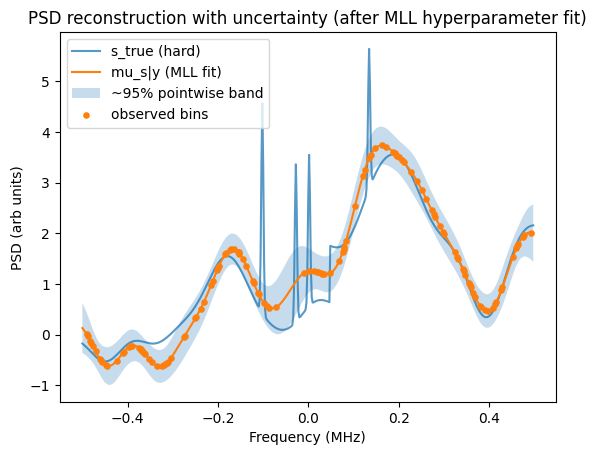

Cell 13 done. Compare residuals and uncertainty to the pre-MLL fit.


In [13]:
# Cell 13: Refit posterior using MLL hyperparameters + residual validation + PSD uncertainty plot

# 1) Rebuild Phi_KL using optimized ell
Phi_KL_opt, lam_opt = build_Phi_KL_fixedR(f, w, ell_f=ell_f_mll, R=R)

# 2) Build A and run posterior with optimized sigma
A_opt = Theta @ Phi_KL_opt
sigma_eps_hat = sigma_eps_mll
sigma2 = sigma_eps_hat**2
inv_sigma2 = 1.0 / sigma2

S = np.eye(R) + inv_sigma2 * (A_opt.T @ A_opt)
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ (inv_sigma2 * (A_opt.T @ y))

# 3) Residuals in measurement space
y_hat = A_opt @ mu_xi
r = (y - y_hat) / sigma_eps_hat

print(f"Using ell_f_mll={ell_f_mll:.3e}, sigma_eps_mll={sigma_eps_mll:.3e}")
print(f"Residual mean = {np.mean(r):.3f}")
print(f"Residual std  = {np.std(r):.3f} (target ~1 if iid Gaussian noise matches)")

# Residual histogram vs N(0,1)
plt.figure()
plt.hist(r, bins=60, density=True, alpha=0.7, label="standardized residuals (MLL)")
xx = np.linspace(-6, 6, 500)
pdf = (1.0 / np.sqrt(2*np.pi)) * np.exp(-0.5 * xx**2)
plt.plot(xx, pdf, label="N(0,1) pdf")
plt.xlabel("r")
plt.ylabel("density")
plt.title("Residual analysis after MLL hyperparameter fit")
plt.legend()
plt.show()

out3 = np.mean(np.abs(r) > 3.0)
out5 = np.mean(np.abs(r) > 5.0)
print(f"Fraction |r|>3: {out3:.3f}  (Gaussian expectation ~0.0027)")
print(f"Fraction |r|>5: {out5:.3f}  (Gaussian expectation ~5.7e-07)")

# 4) PSD posterior mean + uncertainty
mu_s = Phi_KL_opt @ mu_xi
Sigma_s = Phi_KL_opt @ Sigma_xi @ Phi_KL_opt.T
std_s = np.sqrt(np.maximum(np.diag(Sigma_s), 0.0))

z = 1.96
lower = mu_s - z * std_s
upper = mu_s + z * std_s

plt.figure()
plt.plot(f/1e6, s_true, label="s_true (hard)", alpha=0.75)
plt.plot(f/1e6, mu_s, label="mu_s|y (MLL fit)")
plt.fill_between(f/1e6, lower, upper, alpha=0.25, label="~95% pointwise band")
# Optional: show observed-bin markers as in earlier debugging plots
plt.scatter(f[obs_idx]/1e6, mu_s[obs_idx], s=14, label="observed bins", zorder=3)
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (arb units)")
plt.title("PSD reconstruction with uncertainty (after MLL hyperparameter fit)")
plt.legend()
plt.show()

print("Cell 13 done. Compare residuals and uncertainty to the pre-MLL fit.")


Observed y: mean=1.140, std=1.362
Pred y*:   mean=1.124, std(avg)=0.537


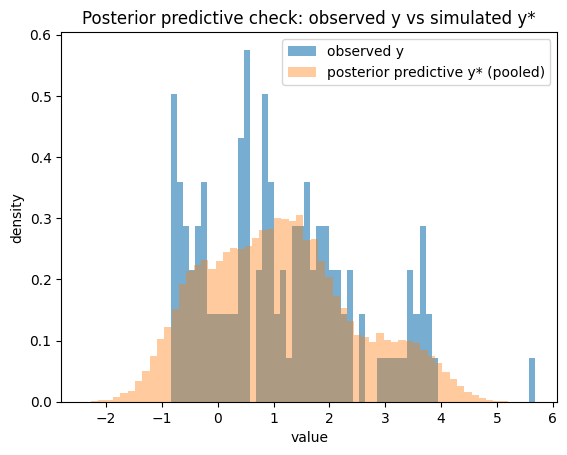

Predictive 95% interval coverage over measurement indices: 0.961
Cell 14 done. Inspect histograms + coverage.


In [14]:
# Cell 14: Posterior predictive check (static)

# We assume you still have from Cell 13:
# A_opt, mu_xi, Sigma_xi, sigma_eps_hat, y

K = 300  # number of predictive samples (increase later if you want)

# Sample xi ~ N(mu_xi, Sigma_xi)
Lx = npl.cholesky(symmetrize(Sigma_xi) + 1e-12*np.eye(R))
Xi_samps = mu_xi[None, :] + (rng.standard_normal((K, R)) @ Lx.T)  # (K,R)

# Predict y* = A xi + eps
Y_star = Xi_samps @ A_opt.T + sigma_eps_hat * rng.standard_normal((K, A_opt.shape[0]))  # (K,N)

# Compare summary stats
y_mean_pred = Y_star.mean(axis=0)
y_std_pred  = Y_star.std(axis=0)

print(f"Observed y: mean={np.mean(y):.3f}, std={np.std(y):.3f}")
print(f"Pred y*:   mean={np.mean(y_mean_pred):.3f}, std(avg)={np.mean(y_std_pred):.3f}")

# Plot distribution of y (observed) vs pooled predictive samples
plt.figure()
plt.hist(y, bins=60, density=True, alpha=0.6, label="observed y")
plt.hist(Y_star.reshape(-1), bins=60, density=True, alpha=0.4, label="posterior predictive y* (pooled)")
plt.xlabel("value")
plt.ylabel("density")
plt.title("Posterior predictive check: observed y vs simulated y*")
plt.legend()
plt.show()

# Coverage check: how often does observed y_i fall in predictive 95% intervals?
lower = np.quantile(Y_star, 0.025, axis=0)
upper = np.quantile(Y_star, 0.975, axis=0)
coverage = np.mean((y >= lower) & (y <= upper))
print(f"Predictive 95% interval coverage over measurement indices: {coverage:.3f}")

print("Cell 14 done. Inspect histograms + coverage.")


T=60, dt=1.0
alpha=0.150, a=exp(-alpha*dt)=0.861, q_eta=2.592e-01
Generated Y shape: (60, 128), Xi_true shape: (60, 20), S_true shape: (60, 512)


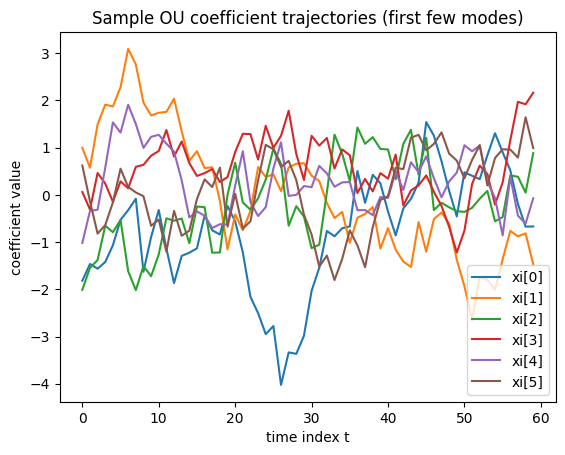

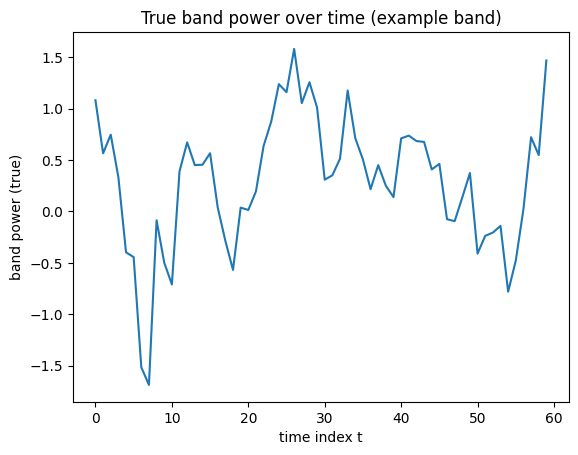

Cell 15 ok: dynamic synthetic dataset created (Xi_true, S_true, Y).


In [15]:
# Cell 15: Dynamic synthetic data generation (OU / AR(1) dynamics in coefficient space)

# We'll use the MLL-optimized basis from Cell 13:
# Phi_KL_opt (M,R), A_opt = Theta @ Phi_KL_opt (N,R)
# If not in memory, rebuild:
try:
    Phi_KL_opt
except NameError:
    Phi_KL_opt, _ = build_Phi_KL_fixedR(f, w, ell_f=ell_f_mll, R=R)
A_opt = Theta @ Phi_KL_opt
N = A_opt.shape[0]

# ---- Time settings ----
T = 60
dt = 1.0  # arbitrary time step (can be seconds; only relative scale matters here)

# ---- OU hyperparameters (mode-independent to start, simplest) ----
# alpha controls correlation time (larger alpha -> faster changes)
# q controls stationary variance (for AR(1): Var(xi) = q_eta / (1-a^2))
alpha = 0.15
a = float(np.exp(-alpha * dt))

xi_stationary_std = 1.0  # we want coefficients ~ N(0,1) stationary-ish
q_eta = (1.0 - a**2) * (xi_stationary_std**2)  # makes Var(xi) approx 1

print(f"T={T}, dt={dt}")
print(f"alpha={alpha:.3f}, a=exp(-alpha*dt)={a:.3f}, q_eta={q_eta:.3e}")

# ---- Generate xi_t sequence (R dims) ----
Xi_true = np.zeros((T, R))
Xi_true[0] = rng.standard_normal(R) * xi_stationary_std
for t in range(1, T):
    Xi_true[t] = a * Xi_true[t-1] + np.sqrt(q_eta) * rng.standard_normal(R)

# ---- Generate PSD sequence ----
S_true = Xi_true @ Phi_KL_opt.T   # (T,M) since s_t = Phi_KL xi_t  -> row form
# (equivalently: (Phi_KL_opt @ Xi_true[t]) for each t)

# ---- Measurement noise model (for dynamic model we'll start with iid Gaussian) ----
sigma_eps_dyn = sigma_eps_mll  # reuse learned sigma as baseline
Y = (Xi_true @ A_opt.T) + sigma_eps_dyn * rng.standard_normal((T, N))  # y_t = A xi_t + eps

print(f"Generated Y shape: {Y.shape}, Xi_true shape: {Xi_true.shape}, S_true shape: {S_true.shape}")

# ---- Quick sanity plots ----
# Plot a few coefficient trajectories
plt.figure()
for n in range(min(6, R)):
    plt.plot(Xi_true[:, n], label=f"xi[{n}]")
plt.xlabel("time index t")
plt.ylabel("coefficient value")
plt.title("Sample OU coefficient trajectories (first few modes)")
plt.legend()
plt.show()

# Plot band power over time for one example band (use same bands list if exists, else make one)
# We'll pick a middle band for demonstration
if 'bands' in globals() and len(bands) > 0:
    k0 = len(bands)//2
    f_lo, f_hi, idx, cB = bands[k0]
else:
    # define a simple band around center frequencies
    f_lo, f_hi = -0.1*B_total, 0.1*B_total
    idx, cB = band_selector_c(f, w, f_lo, f_hi)

pB_true = S_true @ cB  # (T,)
plt.figure()
plt.plot(pB_true)
plt.xlabel("time index t")
plt.ylabel("band power (true)")
plt.title("True band power over time (example band)")
plt.show()

print("Cell 15 ok: dynamic synthetic dataset created (Xi_true, S_true, Y).")


Kalman filter complete. Total log-likelihood = -6636.429
Filtered xi RMSE (over all t,n): 3.794e-01


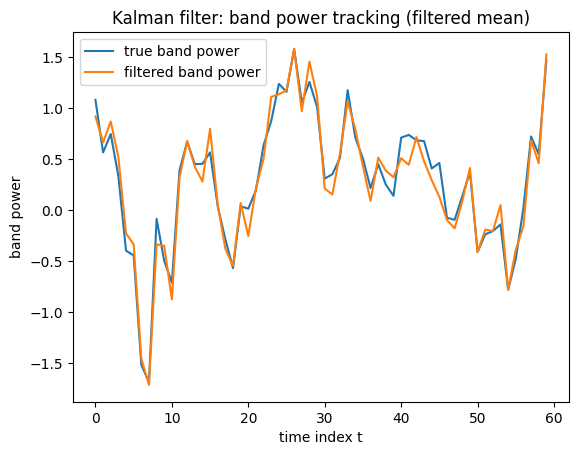

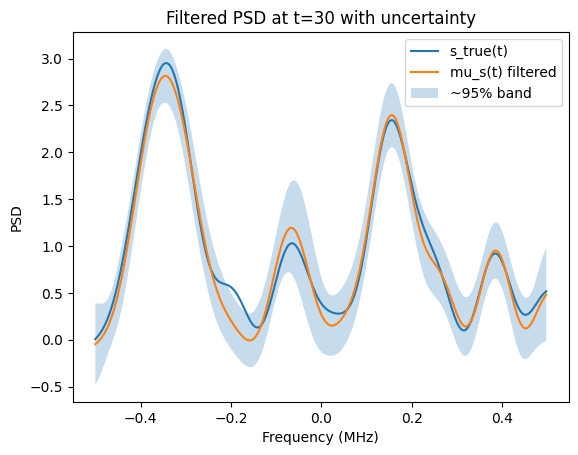

Cell 16 ok: filtering + basic validation plots generated.


In [16]:
# Cell 16: Kalman filtering for dynamic KL coefficients xi_t

# Requirements from Cell 15:
# Y: (T,N), Xi_true: (T,R), Phi_KL_opt: (M,R), A_opt: (N,R)
# a, q_eta, sigma_eps_dyn, T, N, R already set

T, N = Y.shape
R_state = R

F = a * np.eye(R_state)                 # (R,R)
Q = q_eta * np.eye(R_state)             # (R,R)
H = A_opt                               # (N,R)
Rmeas = (sigma_eps_dyn**2) * np.eye(N)  # (N,N)

# Initial prior (stationary-ish)
m = np.zeros(R_state)                   # E[xi_0]
P = np.eye(R_state)                     # Cov[xi_0]

# Storage
m_filt = np.zeros((T, R_state))
P_filt = np.zeros((T, R_state, R_state))
m_pred = np.zeros((T, R_state))
P_pred = np.zeros((T, R_state, R_state))

loglik = 0.0

for t in range(T):
    # ---- Predict ----
    if t == 0:
        m_minus = m
        P_minus = P
    else:
        m_minus = F @ m
        P_minus = F @ P @ F.T + Q

    m_pred[t] = m_minus
    P_pred[t] = P_minus

    # ---- Update ----
    y_t = Y[t]  # (N,)

    S = H @ P_minus @ H.T + Rmeas              # (N,N)
    S = symmetrize(S)

    # Cholesky for stability
    L = npl.cholesky(S + 1e-12*np.eye(N))

    # Kalman gain: K = P_minus H^T S^{-1}
    # Solve S^{-1} via chol solves
    HP = H @ P_minus                           # (N,R)
    # Solve S^{-1} (HP) for efficiency: S X = HP
    X = npl.solve(L, HP)
    Sinv_HP = npl.solve(L.T, X)                # (N,R)
    K = P_minus @ H.T @ Sinv_HP                # (R,R)? wait dims:
    # H.T @ Sinv_HP gives (R,R), then P_minus (R,R) -> (R,R)
    # But K should be (R,N). Let's compute directly:
    # Solve S^{-1} for identity on N-by-N is expensive; do:
    # K = (P_minus H^T) S^{-1}
    PHt = P_minus @ H.T                        # (R,N)
    X2 = npl.solve(L, PHt.T)                   # solve L Z = (P H^T)^T -> (N,R)
    Sinv_PHt_T = npl.solve(L.T, X2)            # (N,R)
    K = Sinv_PHt_T.T                           # (R,N)

    innov = y_t - (H @ m_minus)                # (N,)
    m = m_minus + K @ innov

    # Joseph form for numerical stability:
    I = np.eye(R_state)
    P = (I - K @ H) @ P_minus @ (I - K @ H).T + K @ Rmeas @ K.T
    P = symmetrize(P)

    m_filt[t] = m
    P_filt[t] = P

    # ---- accumulate log-likelihood (optional, useful later for NLPD) ----
    # ll_t = -0.5( innov^T S^{-1} innov + log|S| + N log(2pi) )
    z = npl.solve(L, innov)
    Sinv_innov = npl.solve(L.T, z)
    quad = float(innov @ Sinv_innov)
    logdetS = 2.0 * float(np.sum(np.log(np.diag(L) + 1e-30)))
    loglik += -0.5 * (quad + logdetS + N * np.log(2*np.pi))

print(f"Kalman filter complete. Total log-likelihood = {loglik:.3f}")

# ---- Compare filtered state to truth ----
xi_rmse = float(np.sqrt(np.mean((m_filt - Xi_true)**2)))
print(f"Filtered xi RMSE (over all t,n): {xi_rmse:.3e}")

# ---- Reconstruct PSD mean + band power mean over time ----
S_filt_mean = m_filt @ Phi_KL_opt.T      # (T,M)

# band power over time (same cB from Cell 15)
pB_filt = S_filt_mean @ cB               # (T,)

plt.figure()
plt.plot(pB_true, label="true band power")
plt.plot(pB_filt, label="filtered band power")
plt.xlabel("time index t")
plt.ylabel("band power")
plt.title("Kalman filter: band power tracking (filtered mean)")
plt.legend()
plt.show()

# ---- Visualize a single time slice PSD with uncertainty (optional) ----
# Convert state covariance to PSD covariance diagonal: diag(Phi P Phi^T)
t_show = T // 2
P_t = P_filt[t_show]
mu_s_t = S_filt_mean[t_show]
var_s_t = np.sum((Phi_KL_opt @ P_t) * Phi_KL_opt, axis=1)  # diag(Phi P Phi^T) efficiently
std_s_t = np.sqrt(np.maximum(var_s_t, 0.0))

z = 1.96
plt.figure()
plt.plot(f/1e6, S_true[t_show], label="s_true(t)")
plt.plot(f/1e6, mu_s_t, label="mu_s(t) filtered")
plt.fill_between(f/1e6, mu_s_t - z*std_s_t, mu_s_t + z*std_s_t, alpha=0.25, label="~95% band")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD")
plt.title(f"Filtered PSD at t={t_show} with uncertainty")
plt.legend()
plt.show()

print("Cell 16 ok: filtering + basic validation plots generated.")


RTS smoother complete.
xi RMSE filtered: 3.794e-01
xi RMSE smoothed: 3.275e-01


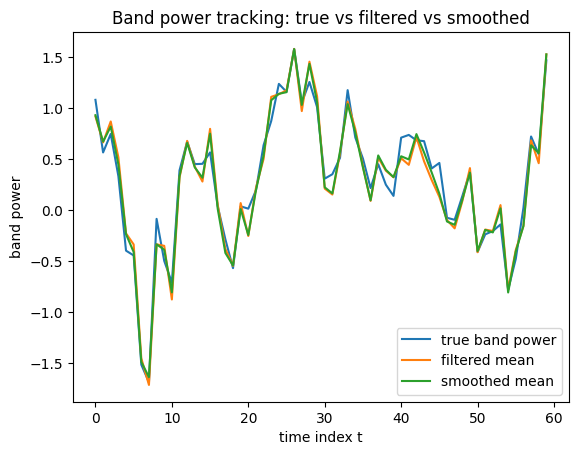

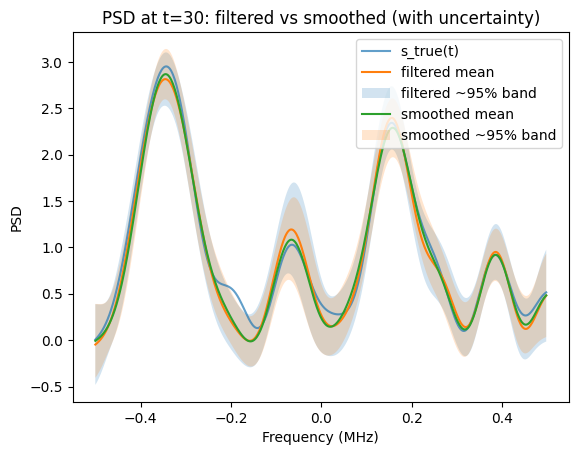

Cell 17 ok: smoothing + comparisons complete.


In [17]:
# Cell 17: RTS smoothing (backward pass)

# Requires from Cell 16:
# m_filt, P_filt, m_pred, P_pred, F, Phi_KL_opt, S_true, pB_true, cB

m_smooth = np.zeros_like(m_filt)
P_smooth = np.zeros_like(P_filt)

# Initialize at final time with filtered estimates
m_smooth[-1] = m_filt[-1]
P_smooth[-1] = P_filt[-1]

I = np.eye(R)

for t in range(T-2, -1, -1):
    # Smoother gain: J_t = P_filt[t] F^T (P_pred[t+1])^{-1}
    Pp = symmetrize(P_pred[t+1])
    Pf = symmetrize(P_filt[t])

    # Solve P_pred^{-1} via Cholesky (stable)
    L = npl.cholesky(Pp + 1e-12*np.eye(R))
    # Compute (P_pred^{-1} (F Pf)^T ) etc with solves
    # J = Pf F^T Pp^{-1}
    # We'll compute X = Pp^{-1} (F Pf)^T then transpose appropriately
    FPf = F @ Pf                               # (R,R)
    X = npl.solve(L, FPf.T)                    # (R,R)
    Pp_inv_FPf_T = npl.solve(L.T, X)           # (R,R)
    J = (Pp_inv_FPf_T).T                       # = Pf F^T Pp^{-1}

    # Smoothed mean
    m_smooth[t] = m_filt[t] + J @ (m_smooth[t+1] - m_pred[t+1])

    # Smoothed covariance
    P_smooth[t] = Pf + J @ (P_smooth[t+1] - Pp) @ J.T
    P_smooth[t] = symmetrize(P_smooth[t])

print("RTS smoother complete.")

# ---- Compare filtered vs smoothed against truth ----
rmse_filt = float(np.sqrt(np.mean((m_filt - Xi_true)**2)))
rmse_smooth = float(np.sqrt(np.mean((m_smooth - Xi_true)**2)))
print(f"xi RMSE filtered: {rmse_filt:.3e}")
print(f"xi RMSE smoothed: {rmse_smooth:.3e}")

# ---- Band power tracking: filtered vs smoothed ----
S_smooth_mean = m_smooth @ Phi_KL_opt.T    # (T,M)
pB_smooth = S_smooth_mean @ cB             # (T,)

plt.figure()
plt.plot(pB_true, label="true band power")
plt.plot(pB_filt, label="filtered mean")
plt.plot(pB_smooth, label="smoothed mean")
plt.xlabel("time index t")
plt.ylabel("band power")
plt.title("Band power tracking: true vs filtered vs smoothed")
plt.legend()
plt.show()

# ---- PSD slice comparison (t_show) with uncertainty ----
t_show = T // 2

# filtered uncertainty diag
var_f = np.sum((Phi_KL_opt @ P_filt[t_show]) * Phi_KL_opt, axis=1)
std_f = np.sqrt(np.maximum(var_f, 0.0))

# smoothed uncertainty diag
var_s = np.sum((Phi_KL_opt @ P_smooth[t_show]) * Phi_KL_opt, axis=1)
std_s = np.sqrt(np.maximum(var_s, 0.0))

mu_f = (m_filt @ Phi_KL_opt.T)[t_show]
mu_s = (m_smooth @ Phi_KL_opt.T)[t_show]

z = 1.96
plt.figure()
plt.plot(f/1e6, S_true[t_show], label="s_true(t)", alpha=0.7)
plt.plot(f/1e6, mu_f, label="filtered mean")
plt.fill_between(f/1e6, mu_f - z*std_f, mu_f + z*std_f, alpha=0.20, label="filtered ~95% band")
plt.plot(f/1e6, mu_s, label="smoothed mean")
plt.fill_between(f/1e6, mu_s - z*std_s, mu_s + z*std_s, alpha=0.20, label="smoothed ~95% band")
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD")
plt.title(f"PSD at t={t_show}: filtered vs smoothed (with uncertainty)")
plt.legend()
plt.show()

print("Cell 17 ok: smoothing + comparisons complete.")


Running expanding-window CV over alpha grid...
 alpha=0.0100  folds=8  mean NLPD=1304.47  std=9.25
 alpha=0.0176  folds=8  mean NLPD=1230.16  std=6.72
 alpha=0.0310  folds=8  mean NLPD=1174.33  std=7.70
 alpha=0.0545  folds=8  mean NLPD=1136.63  std=8.67
 alpha=0.0959  folds=8  mean NLPD=1115.53  std=9.13
 alpha=0.1688  folds=8  mean NLPD=1108.60  std=9.36
 alpha=0.2970  folds=8  mean NLPD=1113.05  std=9.73
 alpha=0.5226  folds=8  mean NLPD=1126.02  std=10.75
 alpha=0.9197  folds=8  mean NLPD=1144.50  std=13.04
 alpha=1.6184  folds=8  mean NLPD=1164.49  std=16.51
 alpha=2.8480  folds=8  mean NLPD=1179.70  std=19.70
 alpha=5.0119  folds=8  mean NLPD=1185.71  std=21.05

Best alpha by CV (min mean NLPD): 0.16876124757881486


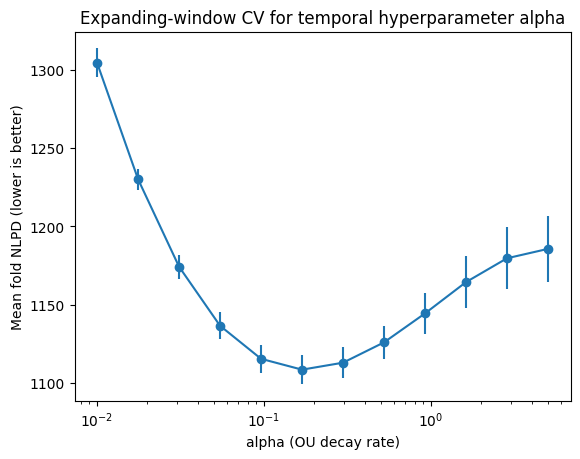

In [18]:
# Cell 18: Expanding-window CV using NLPD to tune alpha (OU dynamics)

def kalman_nlpd_sequence(Y, H, sigma_eps, alpha, dt, m0=None, P0=None):
    """
    Run Kalman filter and return per-time negative log predictive density (NLPD_t)
    where NLPD_t = -log p(y_t | y_{1:t-1}, theta). Uses the *predictive* distribution.
    """
    Y = np.asarray(Y)
    T, N = Y.shape
    R_state = H.shape[1]

    a = float(np.exp(-alpha * dt))
    F = a * np.eye(R_state)
    q_eta = (1.0 - a**2) * 1.0  # stationary var ~1 per coefficient
    Q = q_eta * np.eye(R_state)
    Rmeas = (sigma_eps**2) * np.eye(N)

    if m0 is None:
        m = np.zeros(R_state)
    else:
        m = m0.copy()
    if P0 is None:
        P = np.eye(R_state)
    else:
        P = P0.copy()

    nlpd_t = np.zeros(T)

    for t in range(T):
        # Predict
        if t == 0:
            m_minus = m
            P_minus = P
        else:
            m_minus = F @ m
            P_minus = F @ P @ F.T + Q

        # Predictive distribution of y_t: mean = H m_minus, cov = S
        y_t = Y[t]
        S = H @ P_minus @ H.T + Rmeas
        S = symmetrize(S)

        # Cholesky
        L = npl.cholesky(S + 1e-12*np.eye(N))

        innov = y_t - (H @ m_minus)

        # Compute log p(y_t | past)
        z = npl.solve(L, innov)
        Sinv_innov = npl.solve(L.T, z)
        quad = float(innov @ Sinv_innov)
        logdetS = 2.0 * float(np.sum(np.log(np.diag(L) + 1e-30)))
        ll_t = -0.5 * (quad + logdetS + N * np.log(2*np.pi))
        nlpd_t[t] = -ll_t

        # Update (standard Kalman)
        # K = P_minus H^T S^{-1}
        PHt = P_minus @ H.T               # (R,N)
        X = npl.solve(L, PHt.T)           # (N,R)
        Sinv_PHt_T = npl.solve(L.T, X)    # (N,R)
        K = Sinv_PHt_T.T                  # (R,N)

        m = m_minus + K @ innov
        I = np.eye(R_state)
        P = (I - K @ H) @ P_minus @ (I - K @ H).T + K @ Rmeas @ K.T
        P = symmetrize(P)

    return nlpd_t


def expanding_window_cv_nlpd(Y, H, sigma_eps, dt, alpha, t0_train, t_val, step=5):
    """
    Expanding window CV:
      train = [0 .. t_train-1]
      validate = [t_train .. t_train+t_val-1]
    We slide t_train forward by 'step' until we run out.
    NLPD is computed on validation windows only, using the predictive density.
    """
    T = Y.shape[0]
    fold_scores = []

    t_train = t0_train
    while t_train + t_val <= T:
        # Run KF on data up to end of validation, but only score validation part.
        nlpd_all = kalman_nlpd_sequence(Y[:t_train + t_val], H, sigma_eps, alpha, dt)
        fold_score = float(np.sum(nlpd_all[t_train:t_train + t_val]))
        fold_scores.append(fold_score)

        t_train += step

    return np.array(fold_scores)


# ---- Setup for CV ----
H = A_opt                      # observation matrix (N,R)
sigma_eps = sigma_eps_dyn      # measurement noise used in dynamic data generation
t0_train = 15                  # initial training length
t_val = 10                     # validation horizon per fold
step = 5                       # slide increment

# Candidate alpha values (log-spaced is usually best)
alpha_grid = np.logspace(-2, 0.7, 12)  # ~[0.01 .. 5]
scores_mean = []
scores_std = []

print("Running expanding-window CV over alpha grid...")
for alpha_cand in alpha_grid:
    fold_scores = expanding_window_cv_nlpd(Y, H, sigma_eps, dt, alpha_cand, t0_train, t_val, step=step)
    scores_mean.append(float(np.mean(fold_scores)))
    scores_std.append(float(np.std(fold_scores)))
    print(f" alpha={alpha_cand:.4f}  folds={len(fold_scores)}  mean NLPD={scores_mean[-1]:.2f}  std={scores_std[-1]:.2f}")

scores_mean = np.array(scores_mean)
scores_std = np.array(scores_std)

best_idx = int(np.argmin(scores_mean))
alpha_cv_best = float(alpha_grid[best_idx])

print("\nBest alpha by CV (min mean NLPD):", alpha_cv_best)

# ---- Plot CV curve ----
plt.figure()
plt.errorbar(alpha_grid, scores_mean, yerr=scores_std, fmt="o-")
plt.xscale("log")
plt.xlabel("alpha (OU decay rate)")
plt.ylabel("Mean fold NLPD (lower is better)")
plt.title("Expanding-window CV for temporal hyperparameter alpha")
plt.show()

# Save best alpha for next step
alpha_best = alpha_cv_best


RMSE comparison (xi):
 filtered (old alpha):  3.794e-01
 smoothed (old alpha):  3.275e-01
 filtered (alpha_best): 3.800e-01
 smoothed (alpha_best): 3.285e-01


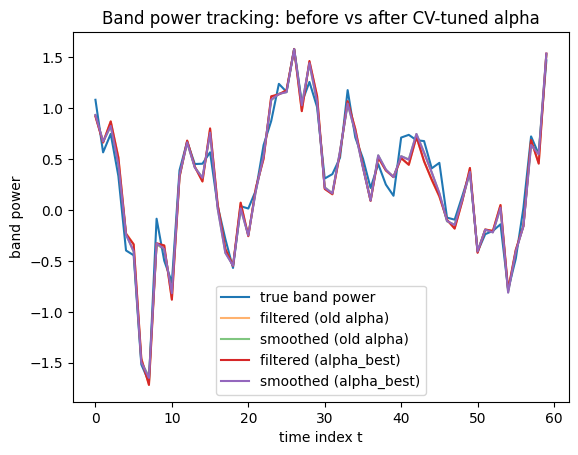

Cell 19 ok: dynamic refit with CV-tuned alpha complete.


In [19]:
# Cell 19: Refit Kalman + RTS using alpha_best (from CV)

alpha = alpha_best
a = float(np.exp(-alpha * dt))
q_eta = (1.0 - a**2) * 1.0

F = a * np.eye(R)
Q = q_eta * np.eye(R)
H = A_opt
Rmeas = (sigma_eps_dyn**2) * np.eye(N)

# ---- Kalman filter pass ----
m = np.zeros(R)
P = np.eye(R)

m_filt2 = np.zeros((T, R))
P_filt2 = np.zeros((T, R, R))
m_pred2 = np.zeros((T, R))
P_pred2 = np.zeros((T, R, R))

for t in range(T):
    if t == 0:
        m_minus, P_minus = m, P
    else:
        m_minus = F @ m
        P_minus = F @ P @ F.T + Q

    m_pred2[t], P_pred2[t] = m_minus, P_minus

    y_t = Y[t]
    S = symmetrize(H @ P_minus @ H.T + Rmeas)
    L = npl.cholesky(S + 1e-12*np.eye(N))

    PHt = P_minus @ H.T
    X = npl.solve(L, PHt.T)
    Sinv_PHt_T = npl.solve(L.T, X)
    K = Sinv_PHt_T.T

    innov = y_t - (H @ m_minus)
    m = m_minus + K @ innov
    I = np.eye(R)
    P = (I - K @ H) @ P_minus @ (I - K @ H).T + K @ Rmeas @ K.T
    P = symmetrize(P)

    m_filt2[t], P_filt2[t] = m, P

# ---- RTS smoother ----
m_smooth2 = np.zeros_like(m_filt2)
P_smooth2 = np.zeros_like(P_filt2)
m_smooth2[-1] = m_filt2[-1]
P_smooth2[-1] = P_filt2[-1]

for t in range(T-2, -1, -1):
    Pp = symmetrize(P_pred2[t+1])
    Pf = symmetrize(P_filt2[t])

    L = npl.cholesky(Pp + 1e-12*np.eye(R))
    FPf = F @ Pf
    X = npl.solve(L, FPf.T)
    Pp_inv_FPf_T = npl.solve(L.T, X)
    J = Pp_inv_FPf_T.T

    m_smooth2[t] = m_filt2[t] + J @ (m_smooth2[t+1] - m_pred2[t+1])
    P_smooth2[t] = Pf + J @ (P_smooth2[t+1] - Pp) @ J.T
    P_smooth2[t] = symmetrize(P_smooth2[t])

# ---- Compare tracking performance ----
rmse_filt_old = float(np.sqrt(np.mean((m_filt - Xi_true)**2)))
rmse_smooth_old = float(np.sqrt(np.mean((m_smooth - Xi_true)**2)))
rmse_filt_new = float(np.sqrt(np.mean((m_filt2 - Xi_true)**2)))
rmse_smooth_new = float(np.sqrt(np.mean((m_smooth2 - Xi_true)**2)))

print("RMSE comparison (xi):")
print(f" filtered (old alpha):  {rmse_filt_old:.3e}")
print(f" smoothed (old alpha):  {rmse_smooth_old:.3e}")
print(f" filtered (alpha_best): {rmse_filt_new:.3e}")
print(f" smoothed (alpha_best): {rmse_smooth_new:.3e}")

# ---- Band power comparison ----
pB_filt2 = (m_filt2 @ Phi_KL_opt.T) @ cB
pB_smooth2 = (m_smooth2 @ Phi_KL_opt.T) @ cB

plt.figure()
plt.plot(pB_true, label="true band power")
plt.plot(pB_filt, label="filtered (old alpha)", alpha=0.6)
plt.plot(pB_smooth, label="smoothed (old alpha)", alpha=0.6)
plt.plot(pB_filt2, label="filtered (alpha_best)")
plt.plot(pB_smooth2, label="smoothed (alpha_best)")
plt.xlabel("time index t")
plt.ylabel("band power")
plt.title("Band power tracking: before vs after CV-tuned alpha")
plt.legend()
plt.show()

print("Cell 19 ok: dynamic refit with CV-tuned alpha complete.")


## real data

Loaded: data\Samples 88 and 108MHz,time to read 0.01s, sample #0.npy
dtype: complex128 shape: (200000,)
is_complex: True
N=200000, DT=0.01s => Fs_est=20.000 MS/s


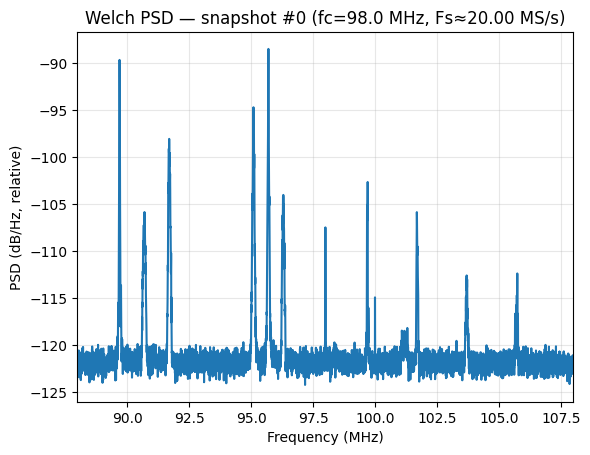

RF span from PSD: 88.000 to 107.998 MHz


In [20]:
# Cell RD-1: Load a real IQ snapshot, sanity-check, Welch PSD, plot on 88–108 MHz axis

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window

# ---- Update this if needed ----
BASE = Path("data")
IDX = 0
DT_ACQ = 0.01          # seconds per snapshot (given)
FC = 98e6              # center frequency (given)

file_path = BASE / f"Samples 88 and 108MHz,time to read 0.01s, sample #{IDX}.npy"
x = np.load(file_path)

print("Loaded:", file_path)
print("dtype:", x.dtype, "shape:", x.shape)

# Basic shape handling
x = np.asarray(x).reshape(-1)

# Check complex IQ
is_complex = np.iscomplexobj(x)
print("is_complex:", is_complex)
if not is_complex:
    raise ValueError("Expected complex IQ in .npy, but array is not complex.")

# Estimate Fs from sample count and acquisition time
Fs_est = len(x) / DT_ACQ
print(f"N={len(x)}, DT={DT_ACQ}s => Fs_est={Fs_est/1e6:.3f} MS/s")

# Use estimated Fs unless you want to force 20e6
Fs = Fs_est

# Remove DC offset (common for HackRF)
x = x - np.mean(x)

# ---- Welch PSD ----
# Choose nperseg; must be <= len(x)
nperseg = 8192
noverlap = nperseg // 2
window = get_window("hann", nperseg, fftbins=True)

# welch returns one-sided for real signals; for complex it returns two-sided if return_onesided=False
f_baseband, Pxx = welch(
    x,
    fs=Fs,
    window=window,
    nperseg=nperseg,
    noverlap=noverlap,
    nfft=nperseg,
    detrend=False,
    return_onesided=False,
    scaling="density",
    average="mean",
)

# Shift to center at 0 Hz, then shift to RF around FC
f_baseband = np.fft.fftshift(f_baseband)     # Hz, roughly [-Fs/2, Fs/2)
Pxx = np.fft.fftshift(Pxx)

f_rf = FC + f_baseband                       # Hz, absolute RF axis

# ---- Plot ----
plt.figure()
plt.plot(f_rf / 1e6, 10*np.log10(Pxx + 1e-30))
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz, relative)")
plt.title(f"Welch PSD — snapshot #{IDX} (fc={FC/1e6:.1f} MHz, Fs≈{Fs/1e6:.2f} MS/s)")
plt.xlim(88, 108)  # focus on FM band
plt.grid(True, alpha=0.3)
plt.show()

# Quick checks: does the axis actually cover 88–108?
print(f"RF span from PSD: {f_rf.min()/1e6:.3f} to {f_rf.max()/1e6:.3f} MHz")

Computing PSDs: 100%|██████████| 100/100 [00:02<00:00, 40.58it/s]


Y_psd shape: (100, 8192)
Frequency grid: 88.000 to 107.998 MHz


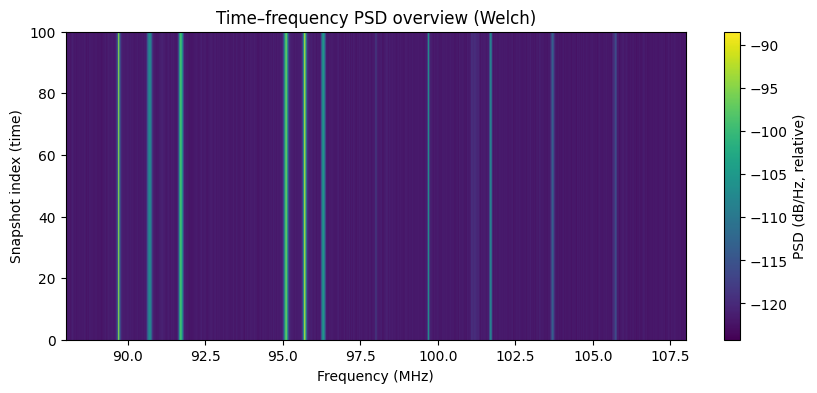

In [21]:
# Cell RD-2: Load all snapshots and build PSD measurement matrix Y[t, i]
from tqdm import trange

DATA_DIR = Path(r"data")
DT_ACQ = 0.01
FC = 98e6

# Welch parameters (keep fixed!)
nperseg = 8192
noverlap = nperseg // 2
window = get_window("hann", nperseg, fftbins=True)

T = 100
Y_list = []

for t in trange(T, desc="Computing PSDs"):
    x = np.load(DATA_DIR / f"Samples 88 and 108MHz,time to read 0.01s, sample #{IDX}.npy")
    x = np.asarray(x).reshape(-1)
    x = x - np.mean(x)

    Fs = len(x) / DT_ACQ

    f_bb, Pxx = welch(
        x,
        fs=Fs,
        window=window,
        nperseg=nperseg,
        noverlap=noverlap,
        nfft=nperseg,
        detrend=False,
        return_onesided=False,
        scaling="density",
        average="mean",
    )

    f_bb = np.fft.fftshift(f_bb)
    Pxx = np.fft.fftshift(Pxx)

    if t == 0:
        f_rf = FC + f_bb
        M = len(Pxx)
    else:
        # sanity: grid consistency
        assert np.allclose(f_rf, FC + f_bb)

    Y_list.append(Pxx)

Y_psd = np.vstack(Y_list)   # shape (T, M)

print("Y_psd shape:", Y_psd.shape)
print(f"Frequency grid: {f_rf[0]/1e6:.3f} to {f_rf[-1]/1e6:.3f} MHz")

# ---- Time–frequency overview (log scale for visualization only) ----
plt.figure(figsize=(10, 4))
plt.imshow(
    10*np.log10(Y_psd + 1e-30),
    aspect="auto",
    origin="lower",
    extent=[f_rf[0]/1e6, f_rf[-1]/1e6, 0, T],
    cmap="viridis"
)
plt.colorbar(label="PSD (dB/Hz, relative)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Snapshot index (time)")
plt.title("Time–frequency PSD overview (Welch)")
plt.show()


M=8192, df=2441.406 Hz, Fs≈20.000 MS/s
sum(w)=20.000000 MHz (should equal Fs≈20.000000 MHz)
Quiet mask uses lowest 25% bins -> 2048/8192 bins


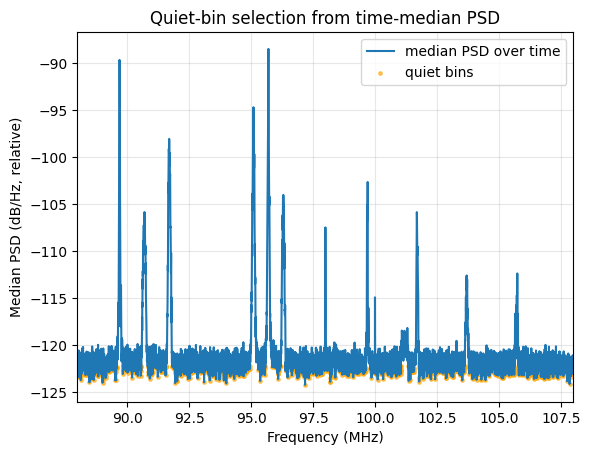

sigma_eps_t: median=4.399e-14, min=4.399e-14, max=4.399e-14


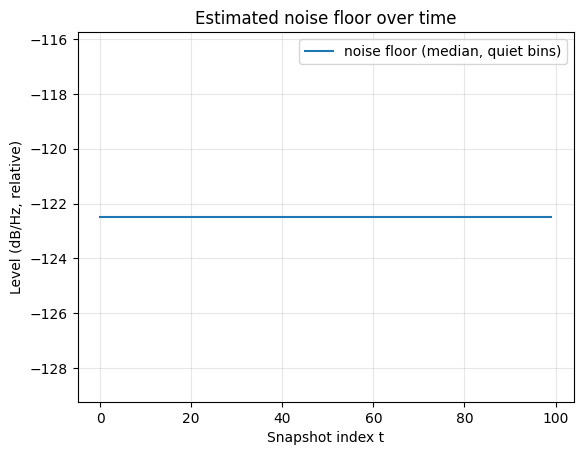

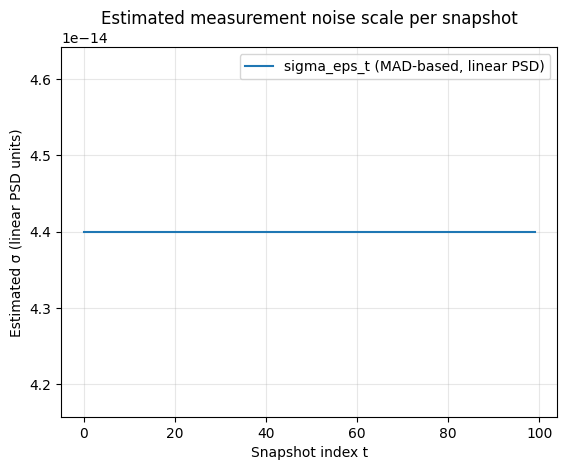

RD-3 ok: weights + initial noise model ready (quiet_mask, sigma_eps_t).


In [22]:
# Cell RD-3: Grid weights + initial noise estimation from "quiet" bins

import numpy as np
import matplotlib.pyplot as plt

# Frequency grid (Hz) and PSD matrix from RD-2
f = f_rf.copy()           # (M,)
T, M = Y_psd.shape

# Sample rate inferred from grid spacing
df = float(np.mean(np.diff(f)))          # Hz
Fs = df * M                              # Hz (should be ~20e6)
w = np.full(M, df)                       # quadrature weights

print(f"M={M}, df={df:.3f} Hz, Fs≈{Fs/1e6:.3f} MS/s")
print(f"sum(w)={np.sum(w)/1e6:.6f} MHz (should equal Fs≈{Fs/1e6:.6f} MHz)")

# Validation
assert abs(np.sum(w) - Fs) < 1e-6 * Fs

# ---- Build a "quiet frequency bins" mask from time-median PSD ----
# Idea: across time, strong FM stations will show high median power; quiet bins have low median.
med_over_time = np.median(Y_psd, axis=0)          # (M,)

# Take lowest fraction as "quiet" (adjustable)
quiet_frac = 0.25
thr = np.quantile(med_over_time, quiet_frac)
quiet_mask = med_over_time <= thr
quiet_count = int(np.sum(quiet_mask))

print(f"Quiet mask uses lowest {quiet_frac*100:.0f}% bins -> {quiet_count}/{M} bins")

# Plot median PSD and highlight quiet region
plt.figure()
plt.plot(f/1e6, 10*np.log10(med_over_time + 1e-30), label="median PSD over time")
plt.scatter((f[quiet_mask]/1e6),
            10*np.log10(med_over_time[quiet_mask] + 1e-30), c="orange",
            s=6, label="quiet bins", alpha=0.6)
plt.xlim(88, 108)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Median PSD (dB/Hz, relative)")
plt.title("Quiet-bin selection from time-median PSD")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ---- Estimate per-snapshot sigma_eps_t (scalar) in linear PSD domain ----
# We center the quiet-bin PSD values by their median to estimate fluctuation scale.
def mad(x):
    x = np.asarray(x)
    m = np.median(x)
    return np.median(np.abs(x - m))

sigma_eps_t = np.zeros(T)
noise_floor_t = np.zeros(T)

for t in range(T):
    yq = Y_psd[t, quiet_mask]
    noise_floor_t[t] = np.median(yq)  # robust "floor" estimate (linear)
    # noise std estimate around the floor (MAD->std for Gaussian)
    sigma_eps_t[t] = 1.4826 * mad(yq)

print(f"sigma_eps_t: median={np.median(sigma_eps_t):.3e}, min={sigma_eps_t.min():.3e}, max={sigma_eps_t.max():.3e}")

# Plot estimated noise floor and sigma over time
plt.figure()
plt.plot(10*np.log10(noise_floor_t + 1e-30), label="noise floor (median, quiet bins)")
plt.xlabel("Snapshot index t")
plt.ylabel("Level (dB/Hz, relative)")
plt.title("Estimated noise floor over time")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

plt.figure()
plt.plot(sigma_eps_t, label="sigma_eps_t (MAD-based, linear PSD)")
plt.xlabel("Snapshot index t")
plt.ylabel("Estimated σ (linear PSD units)")
plt.title("Estimated measurement noise scale per snapshot")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("RD-3 ok: weights + initial noise model ready (quiet_mask, sigma_eps_t).")

B_total=20.000 MHz, ell_f_init=2.000 MHz
Chosen R=20 for cumulative ratio 0.9910 (target=0.99)
Max orthonormality error = 1.887e-15


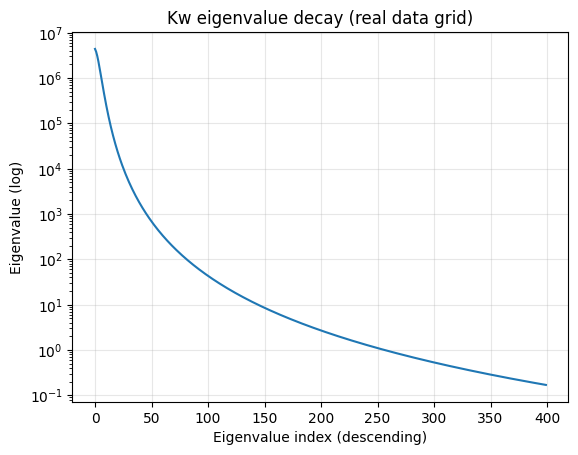

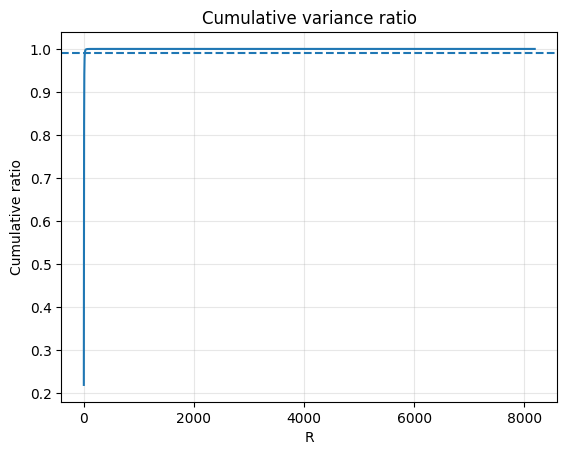

RD-4 ok: Phi_KL built for real data (Phi_KL, R, ell_f_init).


In [23]:
# Cell RD-4: Real-data KL basis (Kw -> eig -> choose R -> Phi_KL) + checks

import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

def matern32_kernel_1d(x: np.ndarray, y: np.ndarray, ell: float) -> np.ndarray:
    x = x[:, None]
    y = y[None, :]
    r = np.abs(x - y)
    a = np.sqrt(3.0) * r / ell
    return (1.0 + a) * np.exp(-a)

def symmetrize(M: np.ndarray) -> np.ndarray:
    return 0.5 * (M + M.T)

# Use real frequency grid f (Hz) and weights w from RD-3
B_total = float(np.sum(w))   # should be Fs
sqrtw = np.sqrt(w)

# Initial lengthscale guess (we'll optimize later)
ell_f_init = 0.1 * B_total   # e.g., 2 MHz if B_total=20 MHz

print(f"B_total={B_total/1e6:.3f} MHz, ell_f_init={ell_f_init/1e6:.3f} MHz")

# Build Kw
K = matern32_kernel_1d(f, f, ell=ell_f_init)
Kw = K * (sqrtw[:, None] * sqrtw[None, :])
Kw = symmetrize(Kw)

# Eigendecomposition
evals, evecs = npl.eigh(Kw)                 # ascending
idx = np.argsort(evals)[::-1]               # descending
evals = np.maximum(evals[idx], 0.0)
evecs = evecs[:, idx]

cum = np.cumsum(evals)
cum_ratio = cum / (cum[-1] + 1e-30)

target = 0.99
R = int(np.searchsorted(cum_ratio, target) + 1)
R = max(1, min(R, M))

print(f"Chosen R={R} for cumulative ratio {cum_ratio[R-1]:.4f} (target={target})")

lam = evals[:R]
V = evecs[:, :R]

# Eigenfunctions and Phi_KL
Phi = V / sqrtw[:, None]               # (M,R)
Phi_KL = Phi * np.sqrt(lam)[None, :]   # (M,R)

# Validate weighted orthonormality: Phi^T diag(w) Phi ≈ I
G = Phi.T @ (w[:, None] * Phi)
ortho_err = np.max(np.abs(G - np.eye(R)))
print(f"Max orthonormality error = {ortho_err:.3e}")
assert ortho_err < 5e-6, "Weighted orthonormality check failed."

# Diagnostics
plt.figure()
plt.semilogy(evals[:min(400, M)])
plt.xlabel("Eigenvalue index (descending)")
plt.ylabel("Eigenvalue (log)")
plt.title("Kw eigenvalue decay (real data grid)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure()
plt.plot(cum_ratio)
plt.axhline(target, linestyle="--")
plt.xlabel("R")
plt.ylabel("Cumulative ratio")
plt.title("Cumulative variance ratio")
plt.grid(True, alpha=0.3)
plt.show()

print("RD-4 ok: Phi_KL built for real data (Phi_KL, R, ell_f_init).")


In [24]:
# Cell RD-5: Static hyperparameter optimization on REAL data (optimize ell_f, sigma_eps)

import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# --- Helpers (same as before) ---
def symmetrize(M: np.ndarray) -> np.ndarray:
    return 0.5 * (M + M.T)

def matern32_kernel_1d(x: np.ndarray, y: np.ndarray, ell: float) -> np.ndarray:
    x = x[:, None]
    y = y[None, :]
    r = np.abs(x - y)
    a = np.sqrt(3.0) * r / ell
    return (1.0 + a) * np.exp(-a)

def build_Phi_KL_fixedR(f, w, ell_f, R):
    """
    Build Phi_KL (M,R) for a given ell_f on the real grid.
    """
    sqrtw = np.sqrt(w)
    K = matern32_kernel_1d(f, f, ell=ell_f)
    Kw = symmetrize(K * (sqrtw[:, None] * sqrtw[None, :]))

    evals, evecs = npl.eigh(Kw)
    idx = np.argsort(evals)[::-1]
    evals = np.maximum(evals[idx], 0.0)
    evecs = evecs[:, idx]

    lam = evals[:R]
    V = evecs[:, :R]
    Phi = V / sqrtw[:, None]
    Phi_KL = Phi * np.sqrt(lam)[None, :]
    return Phi_KL

def log_marginal_likelihood_y(y, A, sigma_eps):
    """
    log p(y | A, sigma_eps) for y = A xi + eps, xi~N(0,I), eps~N(0, sigma^2 I)
    using Woodbury with B = I + (1/sigma^2) A^T A.
    """
    y = np.asarray(y).reshape(-1)
    N, Rloc = A.shape
    sigma2 = float(sigma_eps**2)
    if sigma2 <= 0:
        return -np.inf

    AtA = A.T @ A
    B = symmetrize(np.eye(Rloc) + (1.0/sigma2) * AtA)

    try:
        L = npl.cholesky(B)
    except npl.LinAlgError:
        return -np.inf

    Aty = A.T @ y
    v = npl.solve(L, Aty)
    Binv_Aty = npl.solve(L.T, v)

    yTy = float(y @ y)
    corr = float(Aty @ Binv_Aty)
    quad = (1.0/sigma2) * yTy - (1.0/(sigma2**2)) * corr

    logdetB = 2.0 * float(np.sum(np.log(np.diag(L) + 1e-30)))
    logdetC = N * np.log(sigma2) + logdetB

    ll = -0.5 * quad - 0.5 * logdetC - 0.5 * N * np.log(2.0*np.pi)
    return float(ll)

# --- 1) Build y_excess for each snapshot ---
# Use noise_floor_t from RD-3 (median of quiet bins, linear units)
# y_excess = max(Y_psd - noise_floor_t, 0)  (clamp avoids negative "power")
Y_excess = Y_psd - noise_floor_t[:, None]
Y_excess = np.maximum(Y_excess, 0.0)

print("Y_excess shape:", Y_excess.shape)
print("Example floor (dB/Hz):", 10*np.log10(np.median(noise_floor_t) + 1e-30))

# --- 2) Choose representative snapshots for fitting ---
fit_idx = np.array([0, 25, 50, 75])  # simple and reproducible
# (If you prefer, we can use more, but this is a good start.)
print("Fitting snapshots:", fit_idx.tolist())

# --- 3) Objective: negative summed log ML over chosen snapshots ---
R_fixed = R  # should be 20

# def neg_sum_logml(x):
#     log_ell, log_sigma = float(x[0]), float(x[1])
#     ell = float(np.exp(log_ell))
#     sig = float(np.exp(log_sigma))

#     Phi_KL = build_Phi_KL_fixedR(f, w, ell_f=ell, R=R_fixed)
#     A = Phi_KL  # Theta = I in PSD domain

#     ll_sum = 0.0
#     for t in fit_idx:
#         ll_sum += log_marginal_likelihood_y(Y_excess[t], A, sig)

#     if not np.isfinite(ll_sum):
#         return 1e30
#     return -ll_sum

# # --- 4) Bounds + init ---
# B_total = float(np.sum(w))          # ~20 MHz
# ell_min = 1e-3 * B_total
# ell_max = 1.0  * B_total

# # sigma bounds: based on your sigma_eps_t estimate (linear units)
# sig0 = float(np.median(sigma_eps_t))
# sigma_min = 0.1 * sig0
# sigma_max = 10.0 * sig0

# x0 = np.array([np.log(np.clip(0.1 * B_total, ell_min, ell_max)),
#                np.log(np.clip(sig0, sigma_min, sigma_max))])

# bounds = [(np.log(ell_min), np.log(ell_max)),
#           (np.log(sigma_min), np.log(sigma_max))]

# print(f"Init ell={np.exp(x0[0])/1e6:.3f} MHz, sigma={np.exp(x0[1]):.3e}")
# print(f"ell bounds: [{ell_min/1e6:.3f}, {ell_max/1e6:.3f}] MHz")
# print(f"sigma bounds: [{sigma_min:.3e}, {sigma_max:.3e}]")

# res = minimize(neg_sum_logml, x0=x0, method="L-BFGS-B", bounds=bounds, options=dict(maxiter=60))

# ell_opt = float(np.exp(res.x[0]))
# sig_opt = float(np.exp(res.x[1]))
# print("success:", res.success, "| message:", res.message)
# print(f"Optimized ell_f = {ell_opt/1e6:.6f} MHz")
# print(f"Optimized sigma_eps = {sig_opt:.6e} (linear PSD units)")

# # Save for later cells
# ell_f_real = ell_opt
# sigma_eps_real = sig_opt

# # Quick spot-check plot: model fit on one snapshot using optimized params (posterior mean only)
# Phi_KL_opt = build_Phi_KL_fixedR(f, w, ell_f=ell_f_real, R=R_fixed)
# A = Phi_KL_opt

# # Posterior for xi given y: Sigma=(I + A^T A/sigma^2)^-1, mu=Sigma*(A^T y/sigma^2)
# sigma2 = sigma_eps_real**2
# S = np.eye(R_fixed) + (A.T @ A) / sigma2
# Sigma_xi = npl.inv(S)
# t0 = int(fit_idx[0])
# mu_xi = Sigma_xi @ ((A.T @ Y_excess[t0]) / sigma2)
# mu_s_excess = A @ mu_xi

# plt.figure()
# plt.plot(f/1e6, 10*np.log10(Y_psd[t0] + 1e-30), label="raw PSD (dB/Hz)", alpha=0.7)
# plt.plot(f/1e6, 10*np.log10((mu_s_excess + noise_floor_t[t0]) + 1e-30), label="posterior mean (floor+excess)")
# plt.xlim(88, 108)
# plt.xlabel("Frequency (MHz)")
# plt.ylabel("PSD (dB/Hz, relative)")
# plt.title(f"Static fit sanity check on snapshot {t0}")
# plt.legend()
# plt.grid(True, alpha=0.3)
# plt.show()

# print("RD-5 done.")


Y_excess shape: (100, 8192)
Example floor (dB/Hz): -122.48773627808275
Fitting snapshots: [0, 25, 50, 75]


In [25]:
# Cell RD-5a: PSD posterior mean + uncertainty band for one snapshot

import numpy as np
import numpy.linalg as npl
import matplotlib.pyplot as plt

t0 = 0  # snapshot index to visualize

# Rebuild Phi_KL at the optimized ell (ensure we use the same R=20)
Phi_KL_opt = build_Phi_KL_fixedR(f, w, ell_f=ell_f_real, R=R)  # (M,R)
A = Phi_KL_opt  # Theta = I in PSD domain

# Measurement = excess PSD (clamped)
y = Y_excess[t0].copy()

sigma2 = sigma_eps_real**2

# Posterior over xi: Sigma = (I + A^T A / sigma^2)^-1, mu = Sigma * (A^T y / sigma^2)
S = np.eye(R) + (A.T @ A) / sigma2
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ ((A.T @ y) / sigma2)

# Posterior mean of excess PSD
mu_s_excess = A @ mu_xi  # (M,)

# Posterior covariance diagonal of excess PSD: diag(A Sigma_xi A^T)
# Efficient diag computation:
AS = A @ Sigma_xi                       # (M,R)
var_s_excess = np.sum(AS * A, axis=1)   # (M,)
std_s_excess = np.sqrt(np.maximum(var_s_excess, 0.0))

# Add noise floor back for plotting (mean + bands)
floor = noise_floor_t[t0]
mu_total = mu_s_excess + floor
std_total = std_s_excess  # floor treated as deterministic estimate here

z = 1.96
lower = np.maximum(mu_total - z*std_total, 1e-30)  # keep positive for log plot
upper = np.maximum(mu_total + z*std_total, 1e-30)

plt.figure(figsize=(10,4))
plt.plot(f/1e6, 10*np.log10(Y_psd[t0] + 1e-30), label="raw Welch PSD", alpha=0.65)
plt.plot(f/1e6, 10*np.log10(mu_total + 1e-30), label="posterior mean (floor+excess)")
plt.fill_between(f/1e6, 10*np.log10(lower), 10*np.log10(upper), alpha=0.25, label="~95% pointwise band")
plt.axhline(10*np.log10(floor + 1e-30), linestyle="--", alpha=0.6, label="estimated noise floor")
plt.xlim(88, 108)
plt.xlabel("Frequency (MHz)")
plt.ylabel("PSD (dB/Hz, relative)")
plt.title(f"Snapshot {t0}: PSD posterior mean + uncertainty")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

print("RD-5a ok.")


NameError: name 'ell_f_real' is not defined

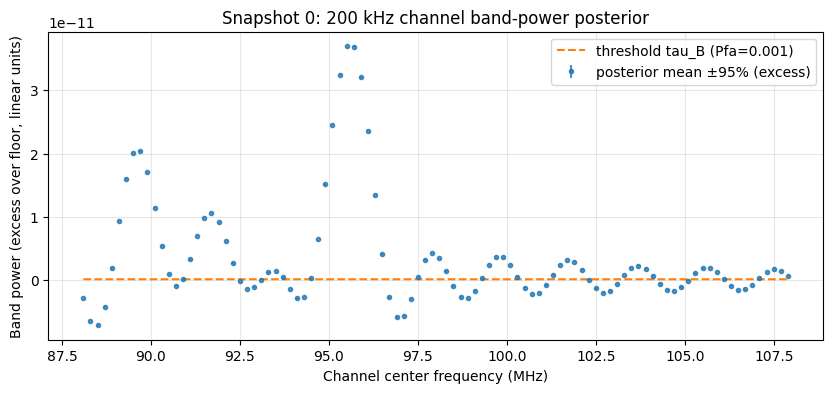

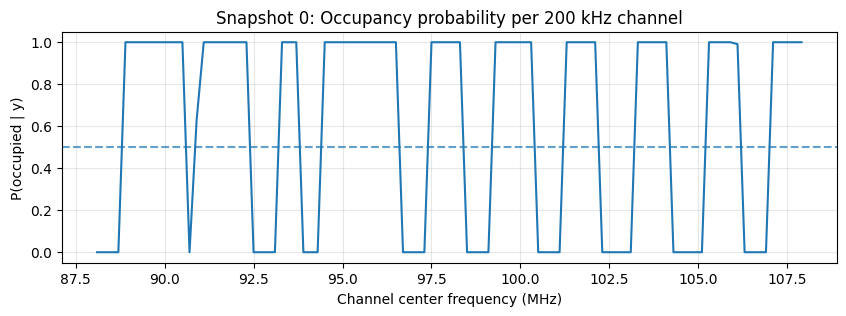

RD-5b ok.


In [26]:
# Cell RD-5b: 200 kHz channel band-power posterior + occupancy probability (snapshot 0)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

t0 = 0

# Reuse from RD-5a if already in memory; otherwise recompute quickly
Phi_KL_opt = build_Phi_KL_fixedR(f, w, ell_f=ell_f_real, R=R)
A = Phi_KL_opt
y = Y_excess[t0].copy()

sigma2 = sigma_eps_real**2
S = np.eye(R) + (A.T @ A) / sigma2
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ ((A.T @ y) / sigma2)

mu_s_excess = A @ mu_xi
Sigma_s_diag = np.sum((A @ Sigma_xi) * A, axis=1)  # diag only, for later optional use

# Full Sigma_s is needed for band-power variance: var(p_B)=c^T Sigma_s c.
# We'll compute var(p_B) without forming Sigma_s:
# Sigma_s = A Sigma_xi A^T  =>  var = c^T A Sigma_xi A^T c = (A^T c)^T Sigma_xi (A^T c)
def band_stats(f, w, mu_s_excess, A, Sigma_xi, f_lo, f_hi):
    idx = np.where((f >= f_lo) & (f < f_hi))[0]
    if len(idx) == 0:
        return None
    c = np.zeros_like(w)
    c[idx] = w[idx] / np.sum(w[idx])  # band-average weight
    muB = float(c @ mu_s_excess)
    Atc = A.T @ c
    varB = float(Atc @ (Sigma_xi @ Atc))
    return (0.5*(f_lo+f_hi), muB, max(varB, 0.0), idx.size)

# Channelization: 200 kHz bins across 88–108 MHz
ch_bw = 200e3
edges = np.arange(88e6, 108e6 + ch_bw, ch_bw)

centers = []
muB = []
stdB = []
nbins = []

for k in range(len(edges)-1):
    out = band_stats(f, w, mu_s_excess, A, Sigma_xi, edges[k], edges[k+1])
    if out is None:
        continue
    c0, m0, v0, n0 = out
    centers.append(c0)
    muB.append(m0)
    stdB.append(np.sqrt(v0))
    nbins.append(n0)

centers = np.array(centers)
muB = np.array(muB)
stdB = np.array(stdB)

# Threshold tau_B:
# Since we modeled EXCESS over noise floor, a natural occupancy threshold is >0.
# But to reduce false alarms, use a small multiple of the estimated noise fluctuation in band-power units.
# Approx band-power noise std under iid sigma: sigma_pB ≈ sigma_eps / sqrt(n_bins_in_band)
# We'll compute per-band tau = k * sigma_pB with k set from a target Pfa.
P_fa = 1e-3
k = norm.isf(P_fa)  # Q^{-1}(Pfa)
sigma_pB = sigma_eps_real / np.sqrt(np.maximum(np.array(nbins), 1))
tauB = k * sigma_pB  # threshold on EXCESS band power

# Occupancy probability: P(p_B > tau | y)
# p_B ~ N(muB, stdB^2)
p_occ = 1.0 - norm.cdf((tauB - muB) / np.maximum(stdB, 1e-30))

# Plot band power posterior mean ±95% and threshold
z = 1.96
plt.figure(figsize=(10,4))
plt.errorbar(centers/1e6, muB, yerr=z*stdB, fmt=".", alpha=0.8, label="posterior mean ±95% (excess)")
plt.plot(centers/1e6, tauB, linestyle="--", label=f"threshold tau_B (Pfa={P_fa})")
plt.xlabel("Channel center frequency (MHz)")
plt.ylabel("Band power (excess over floor, linear units)")
plt.title(f"Snapshot {t0}: 200 kHz channel band-power posterior")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot occupancy probability
plt.figure(figsize=(10,3))
plt.plot(centers/1e6, p_occ)
plt.axhline(0.5, linestyle="--", alpha=0.7)
plt.ylim(-0.05, 1.05)
plt.xlabel("Channel center frequency (MHz)")
plt.ylabel("P(occupied | y)")
plt.title(f"Snapshot {t0}: Occupancy probability per 200 kHz channel")
plt.grid(True, alpha=0.3)
plt.show()

print("RD-5b ok.")


## composite kernel

In [26]:
import numpy as np
import numpy.linalg as npl
from scipy.optimize import minimize

def symmetrize(M):
    return 0.5*(M + M.T)

def matern32_from_r(r, ell):
    a = np.sqrt(3.0) * r / ell
    return (1.0 + a) * np.exp(-a)

def composite_matern32_kernel_1d(x, ell_short, ell_long, a1, a2):
    """
    k = a1^2 * Mat32(ell_short) + a2^2 * Mat32(ell_long)
    """
    x = np.asarray(x)
    r = np.abs(x[:, None] - x[None, :])
    K = (a1**2) * matern32_from_r(r, ell_short) + (a2**2) * matern32_from_r(r, ell_long)
    return K

def build_Phi_KL_fixedR_composite(f, w, R, ell_short, ell_long, a1, a2):
    sqrtw = np.sqrt(w)
    K = composite_matern32_kernel_1d(f, ell_short, ell_long, a1, a2)
    Kw = symmetrize(K * (sqrtw[:, None] * sqrtw[None, :]))

    evals, evecs = npl.eigh(Kw)
    idx = np.argsort(evals)[::-1]
    evals = np.maximum(evals[idx], 0.0)
    evecs = evecs[:, idx]

    lam = evals[:R]
    V = evecs[:, :R]
    Phi = V / sqrtw[:, None]
    Phi_KL = Phi * np.sqrt(lam)[None, :]
    return Phi_KL

def log_marginal_likelihood_y(y, A, sigma_eps):
    """
    y = A xi + eps, xi~N(0,I), eps~N(0,sigma^2 I)
    Uses Woodbury with B = I + A^T A / sigma^2.
    """
    y = np.asarray(y).reshape(-1)
    N, Rloc = A.shape
    sigma2 = float(sigma_eps**2)
    if sigma2 <= 0:
        return -np.inf

    B = symmetrize(np.eye(Rloc) + (A.T @ A) / sigma2)
    try:
        L = npl.cholesky(B)
    except npl.LinAlgError:
        return -np.inf

    Aty = A.T @ y
    v = npl.solve(L, Aty)
    BinvAty = npl.solve(L.T, v)

    yTy = float(y @ y)
    corr = float(Aty @ BinvAty)
    quad = (1.0/sigma2) * yTy - (1.0/(sigma2**2)) * corr

    logdetB = 2.0 * float(np.sum(np.log(np.diag(L) + 1e-30)))
    logdetC = N*np.log(sigma2) + logdetB

    ll = -0.5*(quad + logdetC + N*np.log(2*np.pi))
    return float(ll)

# -------------------------
# Optimization setup
# -------------------------
T, M = Y_excess.shape
B_total = float(np.sum(w))  # ~20 MHz

# Choose snapshots to fit hyperparameters on (representative)
fit_idx = np.array([0, 25, 50, 75])

# We’ll optimize in unconstrained variables:
# u0 = log(ell_short)
# u1 = log(delta) where ell_long = ell_short + exp(u1)
# u2 = log(a1), u3 = log(a2), u4 = log(sigma_eps)
def unpack(u):
    ell_short = float(np.exp(u[0]))
    ell_long  = float(ell_short + np.exp(u[1]))  # ensures ell_long > ell_short
    a1 = float(np.exp(u[2]))
    a2 = float(np.exp(u[3]))
    sigma = float(np.exp(u[4]))
    return ell_short, ell_long, a1, a2, sigma

# Reasonable bounds (in log space) to keep it well-posed
ell_short_min = 1e-4 * B_total     # 2 kHz if B_total=20 MHz
ell_short_max = 0.2  * B_total     # 4 MHz
delta_min     = 1e-4 * B_total     # ensure separation possible
delta_max     = 2.0  * B_total

# amplitudes: keep broad; scaling will adapt
a_min, a_max = 1e-3, 1e3

# sigma: use your estimated sigma_eps_t scale
sig0 = float(np.median(sigma_eps_t))
sigma_min, sigma_max = 0.1*sig0, 10.0*sig0

bounds = [
    (np.log(ell_short_min), np.log(ell_short_max)),  # u0
    (np.log(delta_min),     np.log(delta_max)),      # u1
    (np.log(a_min),         np.log(a_max)),          # u2
    (np.log(a_min),         np.log(a_max)),          # u3
    (np.log(sigma_min),     np.log(sigma_max)),      # u4
]

# Initialize
u0 = np.array([
    np.log(0.02*B_total),         # ell_short ~ 0.4 MHz
    np.log(0.15*B_total),         # delta so ell_long ~ 3.4 MHz
    np.log(1.0),                  # a1
    np.log(1.0),                  # a2
    np.log(sig0),                 # sigma
], dtype=float)

R_fixed = R  # use your chosen rank (e.g., 20 for occupancy envelope)

def neg_sum_logml(u):
    ell_s, ell_l, a1, a2, sigma = unpack(u)

    # Build KL basis for these kernel params
    Phi_KL = build_Phi_KL_fixedR_composite(f, w, R_fixed, ell_s, ell_l, a1, a2)
    A = Phi_KL  # Theta=I in PSD domain

    ll_sum = 0.0
    for t in fit_idx:
        ll_sum += log_marginal_likelihood_y(Y_excess[t], A, sigma)

    if not np.isfinite(ll_sum):
        return 1e30
    return -ll_sum

res = minimize(
    neg_sum_logml,
    x0=u0,
    method="L-BFGS-B",
    bounds=bounds,
    options=dict(maxiter=60),
)

ell_s_opt, ell_l_opt, a1_opt, a2_opt, sigma_opt = unpack(res.x)

print("success:", res.success, "| message:", res.message)
print(f"ell_short = {ell_s_opt/1e6:.6f} MHz")
print(f"ell_long  = {ell_l_opt/1e6:.6f} MHz")
print(f"a1 = {a1_opt:.6g}, a2 = {a2_opt:.6g}")
print(f"sigma_eps = {sigma_opt:.6e} (linear PSD units)")

# Save for later
ell_short_real = ell_s_opt
ell_long_real  = ell_l_opt
a1_real = a1_opt
a2_real = a2_opt
sigma_eps_real_composite = sigma_opt


success: True | message: CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
ell_short = 0.002000 MHz
ell_long  = 40.002000 MHz
a1 = 1000, a2 = 0.001
sigma_eps = 4.399449e-13 (linear PSD units)


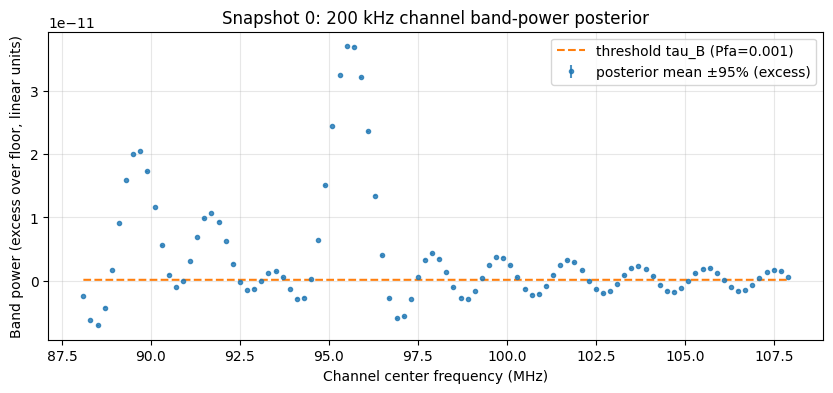

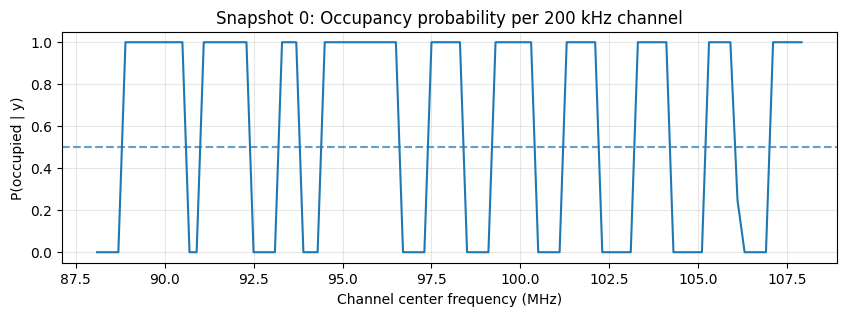

RD-5b ok.


In [27]:
# Cell RD-5b: 200 kHz channel band-power posterior + occupancy probability (snapshot 0)

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

t0 = 0

# Reuse from RD-5a if already in memory; otherwise recompute quickly
Phi_KL_opt = build_Phi_KL_fixedR_composite(
    f, w, R, ell_short_real, ell_long_real, a1_real, a2_real
)
A = Phi_KL_opt
y = Y_excess[t0].copy()

sigma2 = sigma_eps_real_composite**2
S = np.eye(R) + (A.T @ A) / sigma2
Sigma_xi = npl.inv(S)
mu_xi = Sigma_xi @ ((A.T @ y) / sigma2)

mu_s_excess = A @ mu_xi
Sigma_s_diag = np.sum((A @ Sigma_xi) * A, axis=1)  # diag only, for later optional use

# Full Sigma_s is needed for band-power variance: var(p_B)=c^T Sigma_s c.
# We'll compute var(p_B) without forming Sigma_s:
# Sigma_s = A Sigma_xi A^T  =>  var = c^T A Sigma_xi A^T c = (A^T c)^T Sigma_xi (A^T c)
def band_stats(f, w, mu_s_excess, A, Sigma_xi, f_lo, f_hi):
    idx = np.where((f >= f_lo) & (f < f_hi))[0]
    if len(idx) == 0:
        return None
    c = np.zeros_like(w)
    c[idx] = w[idx] / np.sum(w[idx])  # band-average weight
    muB = float(c @ mu_s_excess)
    Atc = A.T @ c
    varB = float(Atc @ (Sigma_xi @ Atc))
    return (0.5*(f_lo+f_hi), muB, max(varB, 0.0), idx.size)

# Channelization: 200 kHz bins across 88–108 MHz
ch_bw = 200e3
edges = np.arange(88e6, 108e6 + ch_bw, ch_bw)

centers = []
muB = []
stdB = []
nbins = []

for k in range(len(edges)-1):
    out = band_stats(f, w, mu_s_excess, A, Sigma_xi, edges[k], edges[k+1])
    if out is None:
        continue
    c0, m0, v0, n0 = out
    centers.append(c0)
    muB.append(m0)
    stdB.append(np.sqrt(v0))
    nbins.append(n0)

centers = np.array(centers)
muB = np.array(muB)
stdB = np.array(stdB)

# Threshold tau_B:
# Since we modeled EXCESS over noise floor, a natural occupancy threshold is >0.
# But to reduce false alarms, use a small multiple of the estimated noise fluctuation in band-power units.
# Approx band-power noise std under iid sigma: sigma_pB ≈ sigma_eps / sqrt(n_bins_in_band)
# We'll compute per-band tau = k * sigma_pB with k set from a target Pfa.
P_fa = 1e-3
k = norm.isf(P_fa)  # Q^{-1}(Pfa)
sigma_pB = sigma_eps_real_composite / np.sqrt(np.maximum(np.array(nbins), 1))
tauB = k * sigma_pB  # threshold on EXCESS band power

# Occupancy probability: P(p_B > tau | y)
# p_B ~ N(muB, stdB^2)
p_occ = 1.0 - norm.cdf((tauB - muB) / np.maximum(stdB, 1e-30))

# Plot band power posterior mean ±95% and threshold
z = 1.96
plt.figure(figsize=(10,4))
plt.errorbar(centers/1e6, muB, yerr=z*stdB, fmt=".", alpha=0.8, label="posterior mean ±95% (excess)")
plt.plot(centers/1e6, tauB, linestyle="--", label=f"threshold tau_B (Pfa={P_fa})")
plt.xlabel("Channel center frequency (MHz)")
plt.ylabel("Band power (excess over floor, linear units)")
plt.title(f"Snapshot {t0}: 200 kHz channel band-power posterior")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

# Plot occupancy probability
plt.figure(figsize=(10,3))
plt.plot(centers/1e6, p_occ)
plt.axhline(0.5, linestyle="--", alpha=0.7)
plt.ylim(-0.05, 1.05)
plt.xlabel("Channel center frequency (MHz)")
plt.ylabel("P(occupied | y)")
plt.title(f"Snapshot {t0}: Occupancy probability per 200 kHz channel")
plt.grid(True, alpha=0.3)
plt.show()

print("RD-5b ok.")
